In [62]:
import glob
import os
import re
import matplotlib.pyplot as plt

In [63]:
def convert_to_us(time_value):
    # time value are strings that has either s, ms, or us at the end
    # convert to us
    if "ms" in time_value:
        return float(time_value[:-2]) * 1000
    elif "us" in time_value:
        return float(time_value[:-2])
    elif "s" in time_value:
        return float(time_value[:-1]) * 1000000
    else:
        raise ValueError("Time value is not in ms, us, or s")

def convert_to_ms(time_value):
    # time value are strings that has either s, ms, or us at the end
    # convert to ms
    if "ms" in time_value:
        return float(time_value[:-2])
    elif "us" in time_value:
        return float(time_value[:-2]) / 1000
    elif "s" in time_value:
        return float(time_value[:-1]) * 1000
    else:
        raise ValueError("Time value is not in ms, us, or s")

In [64]:
hash_table = {"compose-post": 0, "read-home-timeline": 1, "read-user-timeline":2}
def extract_non_2xx_3xx_responses(file_contents):
    """
    Extracts the total number of non 2xx or 3xx responses. If none, returns 0.
    """
    non_2xx_3xx_pattern = r"Non-2xx or 3xx responses:\s+(\d+)"
    match = re.search(non_2xx_3xx_pattern, file_contents)

    if match:
        return int(match.group(1))
    else:
        return 0

def extract_number_timeouts(file_contents):
    """
    Extracts the number of timeouts. If no timeout, returns 0.
    """
    timeout_pattern = r"timeout\s(\d+)"
    match = re.search(timeout_pattern, file_contents)

    if match:
        return int(match.group(1))
    else:
        return 0
    
def extract_latency_metrics_updated(file_contents):
    """
    Extracts 99% latency, min latency, mean latency, and max latency from the file contents.
    Based on the new pattern provided.
    """
    latency_metrics = {}
    
    # Updated regular expressions to find latency metrics based on the new pattern
    latency_pattern = r"Latency\s+(\d+\.\d+s|\d+\.\d+ms|\d+\.\d+us)\s+(\d+\.\d+s|\d+\.\d+ms|\d+\.\d+us)\s+(\d+\.\d+s|\d+\.\d+ms|\d+\.\d+us)"
    match = re.search(latency_pattern, file_contents)

    if match:
        latency_metrics['mean_latency'] = convert_to_ms(match.group(1))
        latency_metrics['stdev_latency'] = convert_to_ms(match.group(2))
        latency_metrics['99%_latency'] = convert_to_ms(match.group(3))
    else:
        latency_metrics['mean_latency'] = "Not found"
        latency_metrics['stdev_latency'] = "Not found"
        latency_metrics['99%_latency'] = "Not found"

    return latency_metrics

def extract_max_latency(file_contents):
    """
    Extracts the max latency from the file contents based on the provided pattern.
    """
    max_latency_pattern = r"\[Max\s*=\s*(\d+\.\d+)"
    match = re.search(max_latency_pattern, file_contents)

    if match:
        return float(match.group(1))
    else:
        return "Not found"

In [65]:
def report_generation(folder_name):
    file_lst = glob.glob(folder_name + "/*.txt")
    file_latency_data = {int(i.split("/")[1].split("_")[0]): [0,0,0] for i in file_lst}
    file_max_latency_data = {int(i.split("/")[1].split("_")[0]): [0,0,0] for i in file_lst}
    file_timeout_data = {int(i.split("/")[1].split("_")[0]): [0,0,0] for i in file_lst}
    file_non_2xx_3xx_data = {int(i.split("/")[1].split("_")[0]): [0,0,0] for i in file_lst}

    for file in file_lst:
        with open(file, 'r') as f:
            file_contents = f.read()
            load = int(file.split("/")[1].split("_")[0])
            service_type = file.split("/")[1].split("_")[1]
            file_latency_data[load][hash_table[service_type]] = extract_latency_metrics_updated(file_contents)
            file_max_latency_data[load][hash_table[service_type]] = extract_max_latency(file_contents)
            file_timeout_data[load][hash_table[service_type]] = extract_number_timeouts(file_contents)
            file_non_2xx_3xx_data[load][hash_table[service_type]] = extract_non_2xx_3xx_responses(file_contents)
    return file_latency_data, file_max_latency_data, file_timeout_data, file_non_2xx_3xx_data

def plot_gragh(x, line_lst, label_lst, xlabel, ylabel, title):
    plt.figure()
    for i, line in enumerate(line_lst):
        plt.plot(x, line, label=label_lst[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()

In [66]:
load_range = [i for i in range(100, 1100, 100)]
linkerd_baseline_latency_data, linkerd_baseline_max_latency_data, linkerd_baseline_timeout_data, linkerd_baseline_non_2xx_3xx_data = report_generation("linkerd_baseline")
no_retry_home_3_compose_25_user_28s_latency_data, no_retry_home_3_compose_25_user_28s_max_latency_data, no_retry_home_3_compose_25_user_28s_timeout_data, no_retry_home_3_compose_25_user_28s_non_2xx_3xx_data = report_generation("no_retry_home_3_compose_25_user_28s")
no_retry_all_5ms_timeout_latency_data, no_retry_all_5ms_timeout_max_latency_data, no_retry_all_5ms_timeout_timeout_data, no_retry_all_5ms_timeout_non_2xx_3xx_data = report_generation("no_retry_all_5ms_timeout")
no_retry_home_4_compose_50_user_100_latency_data, no_retry_home_4_compose_50_user_100_max_latency_data, no_retry_home_4_compose_50_user_100_timeout_data, no_retry_home_4_compose_50_user_100_non_2xx_3xx_data = report_generation("no_retry_home_4_compose_50_user_100")
no_retry_home_6_compose_10_user_3_latency_data, no_retry_home_6_compose_10_user_3_max_latency_data, no_retry_home_6_compose_10_user_3_timeout_data, no_retry_home_6_compose_10_user_3_non_2xx_3xx_data = report_generation("no_retry_home_6_compose_10_user_3")
no_retry_home_7_compose_15_user_50_latency_data, no_retry_home_7_compose_15_user_50_max_latency_data, no_retry_home_7_compose_15_user_50_timeout_data, no_retry_home_7_compose_15_user_50_non_2xx_3xx_data = report_generation("no_retry_home_7_compose_15_user_50")
no_retry_home_2_compose_3s_user_100_latency_data, no_retry_home_2_compose_3s_user_100_max_latency_data, no_retry_home_2_compose_3s_user_100_timeout_data, no_retry_home_2_compose_3s_user_100_non_2xx_3xx_data = report_generation("no_retry_home_2_compose_3s_user_100")
no_retry_home_1_compose_20_user_500_latency_data, no_retry_home_1_compose_20_user_500_max_latency_data, no_retry_home_1_compose_20_user_500_timeout_data, no_retry_home_1_compose_20_user_500_non_2xx_3xx_data = report_generation("no_retry_home_1_compose_20_user_500")
no_retry_home_3_compose_12s_user_28s_latency_data, no_retry_home_3_compose_12s_user_28s_max_latency_data, no_retry_home_3_compose_12s_user_28s_timeout_data, no_retry_home_3_compose_12s_user_28s_non_2xx_3xx_data = report_generation("no_retry_home_3_compose_12s_user_28s")

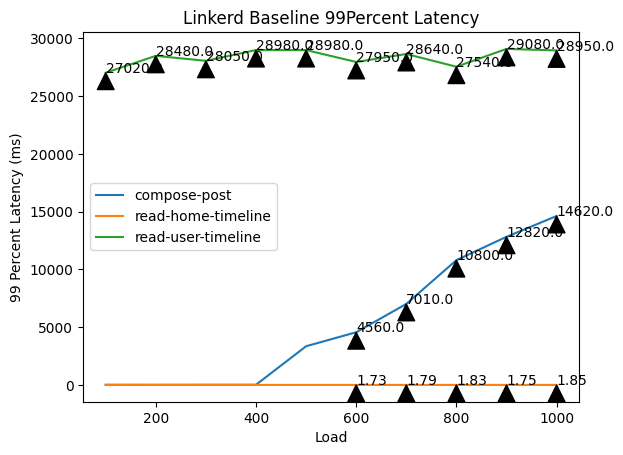

In [67]:
# Generate a graph showing the range of 99% latency for each service type of baseline
linkerd_baseline_99_latency = [[linkerd_baseline_latency_data[i][j]['99%_latency'] for i in load_range] for j in range(3)]
plot_gragh(load_range, linkerd_baseline_99_latency, ["compose-post", "read-home-timeline", "read-user-timeline"], "Load", "99 Percent Latency (ms)", "Linkerd Baseline 99Percent Latency")
# label the last 5 data points
for i, load in enumerate(load_range):
    for j in range(3):
        if i < 5 and j != 2:
            continue
        plt.annotate(str(linkerd_baseline_99_latency[j][i]), xy=(load, linkerd_baseline_99_latency[j][i]), xytext=(load, linkerd_baseline_99_latency[j][i]+0.5), arrowprops=dict(facecolor='black', shrink=0.05))


**Plot 99% Latency with respect to different timeout settings**

In [68]:
def get_all_99_latency(data_dict):
    compose = [data_dict[key][0]['99%_latency'] for key in load_range]
    read_home = [data_dict[key][1]['99%_latency'] for key in load_range]
    read_user = [data_dict[key][2]['99%_latency'] for key in load_range]
    return compose, read_home, read_user

compose_base, read_home_base, read_user_base = get_all_99_latency(linkerd_baseline_latency_data)
latency_99th_compose_3_25_28s, latency_99th_read_home_3_25_28s, latency_99th_read_user_3_25_28s = get_all_99_latency(no_retry_home_3_compose_25_user_28s_latency_data)
latency_99th_compose_all_5ms, latency_99th_read_home_all_5ms, latency_99th_read_user_all_5ms = get_all_99_latency(no_retry_all_5ms_timeout_latency_data)
latency_99th_compose_4_50_100, latency_99th_read_home_4_50_100, latency_99th_read_user_4_50_100 = get_all_99_latency(no_retry_home_4_compose_50_user_100_latency_data)
latency_99th_compose_6_10_3, latency_99th_read_home_6_10_3, latency_99th_read_user_6_10_3 = get_all_99_latency(no_retry_home_6_compose_10_user_3_latency_data)
latency_99th_compose_7_15_50, latency_99th_read_home_7_15_50, latency_99th_read_user_7_15_50 = get_all_99_latency(no_retry_home_7_compose_15_user_50_latency_data)
latency_99th_compose_2_3s_100, latency_99th_read_home_2_3s_100, latency_99th_read_user_2_3s_100 = get_all_99_latency(no_retry_home_2_compose_3s_user_100_latency_data)
latency_99th_compose_1_20_500, latency_99th_read_home_1_20_500, latency_99th_read_user_1_20_500 = get_all_99_latency(no_retry_home_1_compose_20_user_500_latency_data)
latency_99th_compose_3_12s_28s, latency_99th_read_home_3_12s_28s, latency_99th_read_user_3_12s_28s = get_all_99_latency(no_retry_home_3_compose_12s_user_28s_latency_data)

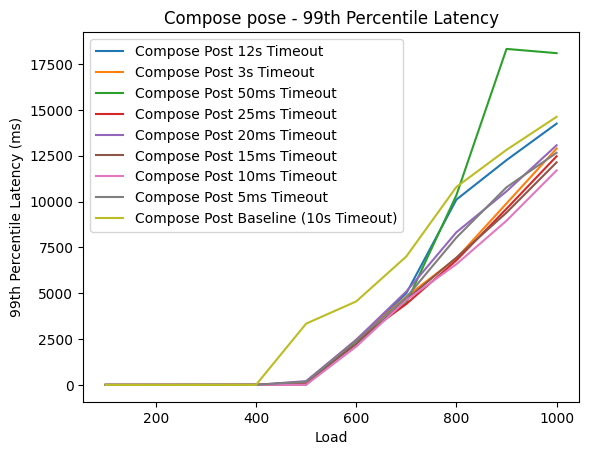

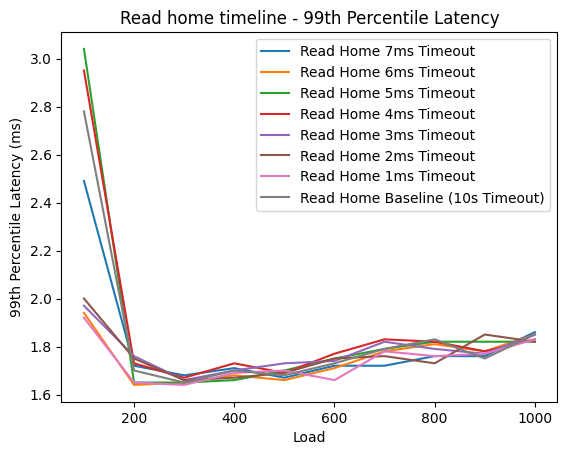

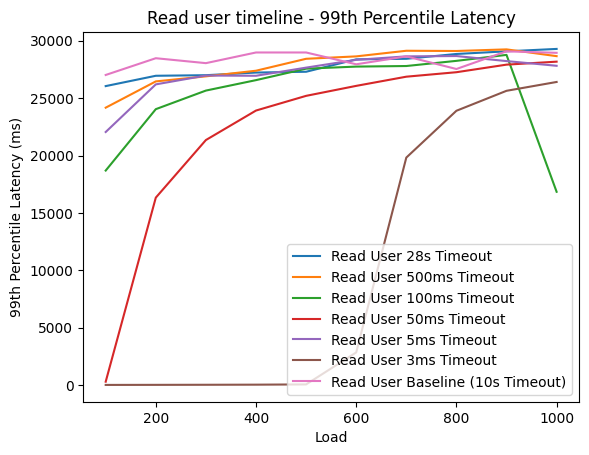

In [98]:
plot_gragh(load_range, [latency_99th_compose_3_12s_28s, latency_99th_compose_2_3s_100, latency_99th_compose_4_50_100, latency_99th_compose_3_25_28s, latency_99th_compose_1_20_500, latency_99th_compose_7_15_50, latency_99th_compose_6_10_3, latency_99th_compose_all_5ms, compose_base],
           ['Compose Post 12s Timeout', 'Compose Post 3s Timeout', 'Compose Post 50ms Timeout', 'Compose Post 25ms Timeout', 'Compose Post 20ms Timeout', 'Compose Post 15ms Timeout', 'Compose Post 10ms Timeout', 'Compose Post 5ms Timeout', 'Compose Post Baseline (10s Timeout)'],
           "Load", '99th Percentile Latency (ms)', 'Compose pose - 99th Percentile Latency')
plot_gragh(load_range, [latency_99th_read_home_7_15_50, latency_99th_read_home_6_10_3, latency_99th_read_home_all_5ms, latency_99th_read_home_4_50_100, latency_99th_read_home_3_12s_28s, latency_99th_read_home_2_3s_100, latency_99th_read_home_1_20_500, read_home_base],
           ['Read Home 7ms Timeout', 'Read Home 6ms Timeout', 'Read Home 5ms Timeout', 'Read Home 4ms Timeout', 'Read Home 3ms Timeout', 'Read Home 2ms Timeout', 'Read Home 1ms Timeout', 'Read Home Baseline (10s Timeout)'],
           "Load", '99th Percentile Latency (ms)', 'Read home timeline - 99th Percentile Latency')
plot_gragh(load_range, [latency_99th_read_user_3_12s_28s, latency_99th_read_user_1_20_500, latency_99th_read_user_4_50_100, latency_99th_read_user_7_15_50, latency_99th_read_user_all_5ms, latency_99th_read_user_6_10_3, read_user_base],
           ['Read User 28s Timeout', 'Read User 500ms Timeout', 'Read User 100ms Timeout', 'Read User 50ms Timeout', 'Read User 5ms Timeout', 'Read User 3ms Timeout', 'Read User Baseline (10s Timeout)'],
           "Load", '99th Percentile Latency (ms)', 'Read user timeline - 99th Percentile Latency')

plt.show()

**Plot Max Latency with respect to different timeout settings**

In [70]:
def get_all_data(data_dict):
    compose = [data_dict[key][0] for key in load_range]
    read_home = [data_dict[key][1] for key in load_range]
    read_user = [data_dict[key][2] for key in load_range]
    return compose, read_home, read_user

compose_base_max, read_home_base_max, read_user_base_max = get_all_data(linkerd_baseline_max_latency_data)
latency_max_compose_3_25_28s, latency_max_read_home_3_25_28s, latency_max_read_user_3_25_28s = get_all_data(no_retry_home_3_compose_25_user_28s_max_latency_data)
latency_max_compose_all_5ms, latency_max_read_home_all_5ms, latency_max_read_user_all_5ms = get_all_data(no_retry_all_5ms_timeout_max_latency_data)
latency_max_compose_4_50_100, latency_max_read_home_4_50_100, latency_max_read_user_4_50_100 = get_all_data(no_retry_home_4_compose_50_user_100_max_latency_data)
latency_max_compose_6_10_3, latency_max_read_home_6_10_3, latency_max_read_user_6_10_3 = get_all_data(no_retry_home_6_compose_10_user_3_max_latency_data)
latency_max_compose_7_15_50, latency_max_read_home_7_15_50, latency_max_read_user_7_15_50 = get_all_data(no_retry_home_7_compose_15_user_50_max_latency_data)
latency_max_compose_2_3s_100, latency_max_read_home_2_3s_100, latency_max_read_user_2_3s_100 = get_all_data(no_retry_home_2_compose_3s_user_100_max_latency_data)
latency_max_compose_1_20_500, latency_max_read_home_1_20_500, latency_max_read_user_1_20_500 = get_all_data(no_retry_home_1_compose_20_user_500_max_latency_data)
latency_max_compose_3_12s_28s, latency_max_read_home_3_12s_28s, latency_max_read_user_3_12s_28s = get_all_data(no_retry_home_3_compose_12s_user_28s_max_latency_data)

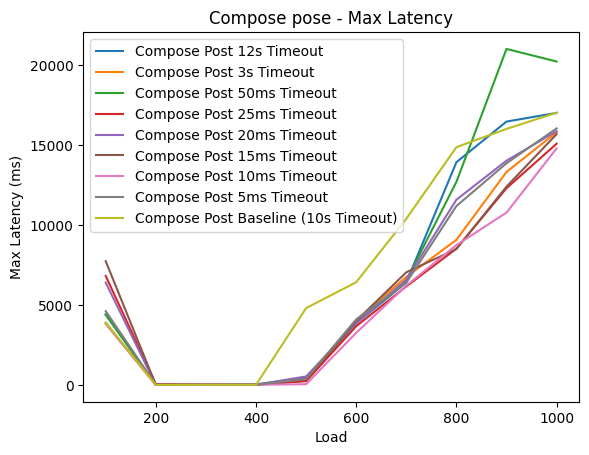

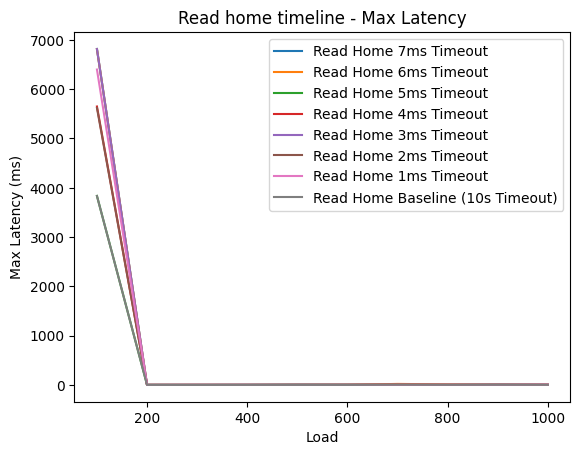

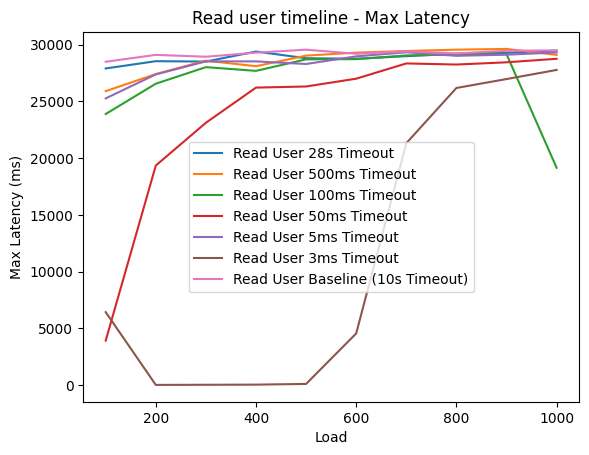

In [99]:
plot_gragh(load_range, [latency_max_compose_3_12s_28s, latency_max_compose_2_3s_100, latency_max_compose_4_50_100, latency_max_compose_3_25_28s, latency_max_compose_1_20_500, latency_max_compose_7_15_50, latency_max_compose_6_10_3, latency_max_compose_all_5ms, compose_base_max],
            ['Compose Post 12s Timeout', 'Compose Post 3s Timeout', 'Compose Post 50ms Timeout', 'Compose Post 25ms Timeout', 'Compose Post 20ms Timeout', 'Compose Post 15ms Timeout', 'Compose Post 10ms Timeout', 'Compose Post 5ms Timeout', 'Compose Post Baseline (10s Timeout)'],
            "Load", 'Max Latency (ms)', 'Compose pose - Max Latency')
plot_gragh(load_range, [latency_max_read_home_7_15_50, latency_max_read_home_6_10_3, latency_max_read_home_all_5ms, latency_max_read_home_4_50_100, latency_max_read_home_3_12s_28s, latency_max_read_home_2_3s_100, latency_max_read_home_1_20_500, read_home_base_max],
            ['Read Home 7ms Timeout', 'Read Home 6ms Timeout', 'Read Home 5ms Timeout', 'Read Home 4ms Timeout', 'Read Home 3ms Timeout', 'Read Home 2ms Timeout', 'Read Home 1ms Timeout', 'Read Home Baseline (10s Timeout)'],
            "Load", 'Max Latency (ms)', 'Read home timeline - Max Latency')
plot_gragh(load_range, [latency_max_read_user_3_12s_28s, latency_max_read_user_1_20_500, latency_max_read_user_4_50_100, latency_max_read_user_7_15_50, latency_max_read_user_all_5ms, latency_max_read_user_6_10_3, read_user_base_max],
            ['Read User 28s Timeout', 'Read User 500ms Timeout', 'Read User 100ms Timeout', 'Read User 50ms Timeout', 'Read User 5ms Timeout', 'Read User 3ms Timeout', 'Read User Baseline (10s Timeout)'],
            "Load", 'Max Latency (ms)', 'Read user timeline - Max Latency')

plt.show()

**Plot Mean Latency with respect to different timeout settings**

In [72]:
def get_all_mean_latency(data_dict):
    compose = [data_dict[key][0]['mean_latency'] for key in load_range]
    read_home = [data_dict[key][1]['mean_latency'] for key in load_range]
    read_user = [data_dict[key][2]['mean_latency'] for key in load_range]
    return compose, read_home, read_user

compose_base_mean, read_home_base_mean, read_user_base_mean = get_all_mean_latency(linkerd_baseline_latency_data)
latency_mean_compose_3_25_28s, latency_mean_read_home_3_25_28s, latency_mean_read_user_3_25_28s = get_all_mean_latency(no_retry_home_3_compose_25_user_28s_latency_data)
latency_mean_compose_all_5ms, latency_mean_read_home_all_5ms, latency_mean_read_user_all_5ms = get_all_mean_latency(no_retry_all_5ms_timeout_latency_data)
latency_mean_compose_4_50_100, latency_mean_read_home_4_50_100, latency_mean_read_user_4_50_100 = get_all_mean_latency(no_retry_home_4_compose_50_user_100_latency_data)
latency_mean_compose_6_10_3, latency_mean_read_home_6_10_3, latency_mean_read_user_6_10_3 = get_all_mean_latency(no_retry_home_6_compose_10_user_3_latency_data)
latency_mean_compose_7_15_50, latency_mean_read_home_7_15_50, latency_mean_read_user_7_15_50 = get_all_mean_latency(no_retry_home_7_compose_15_user_50_latency_data)
latency_mean_compose_2_3s_100, latency_mean_read_home_2_3s_100, latency_mean_read_user_2_3s_100 = get_all_mean_latency(no_retry_home_2_compose_3s_user_100_latency_data)
latency_mean_compose_1_20_500, latency_mean_read_home_1_20_500, latency_mean_read_user_1_20_500 = get_all_mean_latency(no_retry_home_1_compose_20_user_500_latency_data)
latency_mean_compose_3_12s_28s, latency_mean_read_home_3_12s_28s, latency_mean_read_user_3_12s_28s = get_all_mean_latency(no_retry_home_3_compose_12s_user_28s_latency_data)

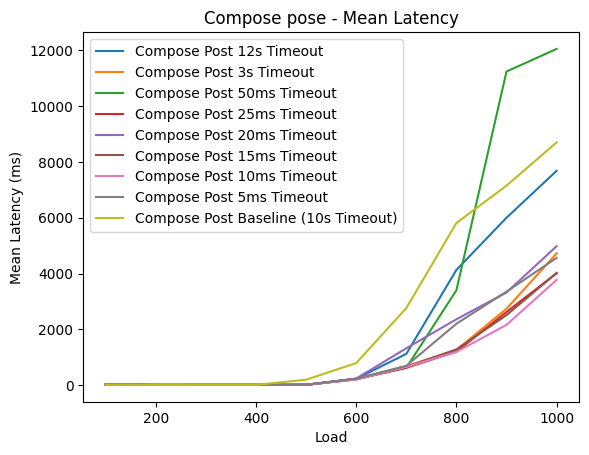

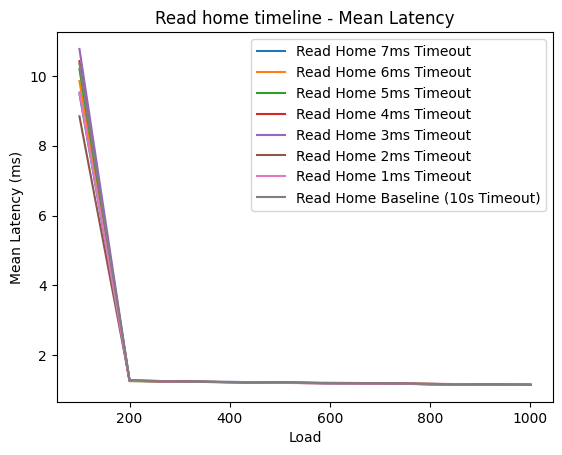

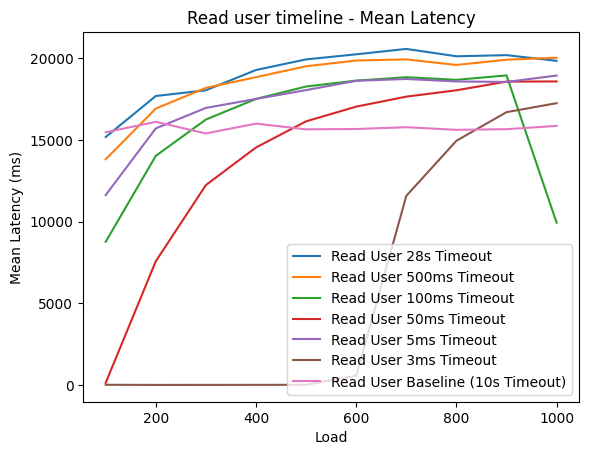

In [100]:
plot_gragh(load_range, [latency_mean_compose_3_12s_28s, latency_mean_compose_2_3s_100, latency_mean_compose_4_50_100, latency_mean_compose_3_25_28s, latency_mean_compose_1_20_500, latency_mean_compose_7_15_50, latency_mean_compose_6_10_3, latency_mean_compose_all_5ms, compose_base_mean],
            ['Compose Post 12s Timeout', 'Compose Post 3s Timeout', 'Compose Post 50ms Timeout', 'Compose Post 25ms Timeout', 'Compose Post 20ms Timeout', 'Compose Post 15ms Timeout', 'Compose Post 10ms Timeout', 'Compose Post 5ms Timeout', 'Compose Post Baseline (10s Timeout)'],
            "Load", 'Mean Latency (ms)', 'Compose pose - Mean Latency')
plot_gragh(load_range, [latency_mean_read_home_7_15_50, latency_mean_read_home_6_10_3, latency_mean_read_home_all_5ms, latency_mean_read_home_4_50_100, latency_mean_read_home_3_12s_28s, latency_mean_read_home_2_3s_100, latency_mean_read_home_1_20_500, read_home_base_mean],
            ['Read Home 7ms Timeout', 'Read Home 6ms Timeout', 'Read Home 5ms Timeout', 'Read Home 4ms Timeout', 'Read Home 3ms Timeout', 'Read Home 2ms Timeout', 'Read Home 1ms Timeout', 'Read Home Baseline (10s Timeout)'],
            "Load", 'Mean Latency (ms)', 'Read home timeline - Mean Latency')
plot_gragh(load_range, [latency_mean_read_user_3_12s_28s, latency_mean_read_user_1_20_500, latency_mean_read_user_4_50_100, latency_mean_read_user_7_15_50, latency_mean_read_user_all_5ms, latency_mean_read_user_6_10_3, read_user_base_mean],
            ['Read User 28s Timeout', 'Read User 500ms Timeout', 'Read User 100ms Timeout', 'Read User 50ms Timeout', 'Read User 5ms Timeout', 'Read User 3ms Timeout', 'Read User Baseline (10s Timeout)'],
            "Load", 'Mean Latency (ms)', 'Read user timeline - Mean Latency')

plt.show()

**Plot number of timeouts with respect to different timeout settings**

In [74]:
compose_base_timeout, read_home_base_timeout, read_user_base_timeout = get_all_data(linkerd_baseline_timeout_data)
timeout_compose_3_25_28s, timeout_read_home_3_25_28s, timeout_read_user_3_25_28s = get_all_data(no_retry_home_3_compose_25_user_28s_timeout_data)
timeout_compose_all_5ms, timeout_read_home_all_5ms, timeout_read_user_all_5ms = get_all_data(no_retry_all_5ms_timeout_timeout_data)
timeout_compose_4_50_100, timeout_read_home_4_50_100, timeout_read_user_4_50_100 = get_all_data(no_retry_home_4_compose_50_user_100_timeout_data)
timeout_compose_6_10_3, timeout_read_home_6_10_3, timeout_read_user_6_10_3 = get_all_data(no_retry_home_6_compose_10_user_3_timeout_data)
timeout_compose_7_15_50, timeout_read_home_7_15_50, timeout_read_user_7_15_50 = get_all_data(no_retry_home_7_compose_15_user_50_timeout_data)
timeout_compose_2_3s_100, timeout_read_home_2_3s_100, timeout_read_user_2_3s_100 = get_all_data(no_retry_home_2_compose_3s_user_100_timeout_data)
timeout_compose_1_20_500, timeout_read_home_1_20_500, timeout_read_user_1_20_500 = get_all_data(no_retry_home_1_compose_20_user_500_timeout_data)
timeout_compose_3_12s_28s, timeout_read_home_3_12s_28s, timeout_read_user_3_12s_28s = get_all_data(no_retry_home_3_compose_12s_user_28s_timeout_data)

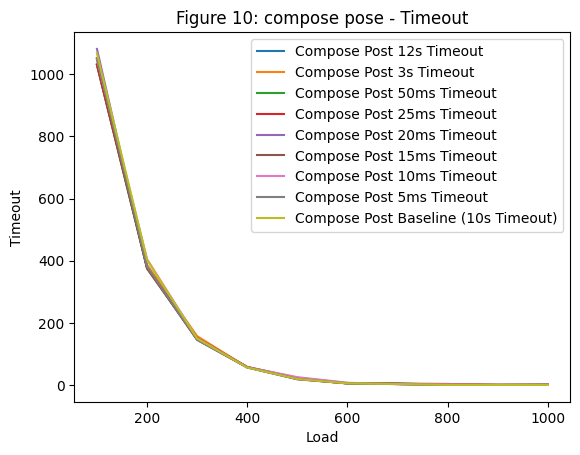

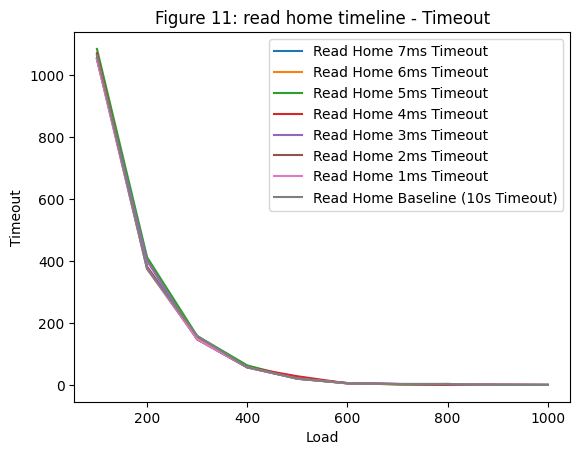

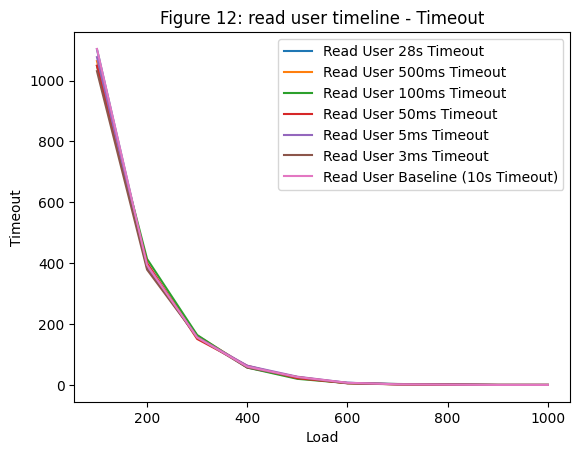

In [75]:
plot_gragh(load_range, [timeout_compose_3_12s_28s, timeout_compose_2_3s_100, timeout_compose_4_50_100, timeout_compose_3_25_28s, timeout_compose_1_20_500, timeout_compose_7_15_50, timeout_compose_6_10_3, timeout_compose_all_5ms, compose_base_timeout],
            ['Compose Post 12s Timeout', 'Compose Post 3s Timeout', 'Compose Post 50ms Timeout', 'Compose Post 25ms Timeout', 'Compose Post 20ms Timeout', 'Compose Post 15ms Timeout', 'Compose Post 10ms Timeout', 'Compose Post 5ms Timeout', 'Compose Post Baseline (10s Timeout)'],
            "Load", 'Timeout', 'Figure 10: compose pose - Timeout')
plot_gragh(load_range, [timeout_read_home_7_15_50, timeout_read_home_6_10_3, timeout_read_home_all_5ms, timeout_read_home_4_50_100, timeout_read_home_3_12s_28s, timeout_read_home_2_3s_100, timeout_read_home_1_20_500, read_home_base_timeout],
            ['Read Home 7ms Timeout', 'Read Home 6ms Timeout', 'Read Home 5ms Timeout', 'Read Home 4ms Timeout', 'Read Home 3ms Timeout', 'Read Home 2ms Timeout', 'Read Home 1ms Timeout', 'Read Home Baseline (10s Timeout)'],
            "Load", 'Timeout', 'Figure 11: read home timeline - Timeout')
plot_gragh(load_range, [timeout_read_user_3_12s_28s, timeout_read_user_1_20_500, timeout_read_user_4_50_100, timeout_read_user_7_15_50, timeout_read_user_all_5ms, timeout_read_user_6_10_3, read_user_base_timeout],
            ['Read User 28s Timeout', 'Read User 500ms Timeout', 'Read User 100ms Timeout', 'Read User 50ms Timeout', 'Read User 5ms Timeout', 'Read User 3ms Timeout', 'Read User Baseline (10s Timeout)'],
            "Load", 'Timeout', 'Figure 12: read user timeline - Timeout')
plt.show()

**Plot number of non 2xx/3xx with respect to different timeout settings**

In [76]:
compose_base_non_2xx_3xx, read_home_base_non_2xx_3xx, read_user_base_non_2xx_3xx = get_all_data(linkerd_baseline_non_2xx_3xx_data)
non_2xx_3xx_compose_3_25_28s, non_2xx_3xx_read_home_3_25_28s, non_2xx_3xx_read_user_3_25_28s = get_all_data(no_retry_home_3_compose_25_user_28s_non_2xx_3xx_data)
non_2xx_3xx_compose_all_5ms, non_2xx_3xx_read_home_all_5ms, non_2xx_3xx_read_user_all_5ms = get_all_data(no_retry_all_5ms_timeout_non_2xx_3xx_data)
non_2xx_3xx_compose_4_50_100, non_2xx_3xx_read_home_4_50_100, non_2xx_3xx_read_user_4_50_100 = get_all_data(no_retry_home_4_compose_50_user_100_non_2xx_3xx_data)
non_2xx_3xx_compose_6_10_3, non_2xx_3xx_read_home_6_10_3, non_2xx_3xx_read_user_6_10_3 = get_all_data(no_retry_home_6_compose_10_user_3_non_2xx_3xx_data)
non_2xx_3xx_compose_7_15_50, non_2xx_3xx_read_home_7_15_50, non_2xx_3xx_read_user_7_15_50 = get_all_data(no_retry_home_7_compose_15_user_50_non_2xx_3xx_data)
non_2xx_3xx_compose_2_3s_100, non_2xx_3xx_read_home_2_3s_100, non_2xx_3xx_read_user_2_3s_100 = get_all_data(no_retry_home_2_compose_3s_user_100_non_2xx_3xx_data)
non_2xx_3xx_compose_1_20_500, non_2xx_3xx_read_home_1_20_500, non_2xx_3xx_read_user_1_20_500 = get_all_data(no_retry_home_1_compose_20_user_500_non_2xx_3xx_data)
non_2xx_3xx_compose_3_12s_28s, non_2xx_3xx_read_home_3_12s_28s, non_2xx_3xx_read_user_3_12s_28s = get_all_data(no_retry_home_3_compose_12s_user_28s_non_2xx_3xx_data)

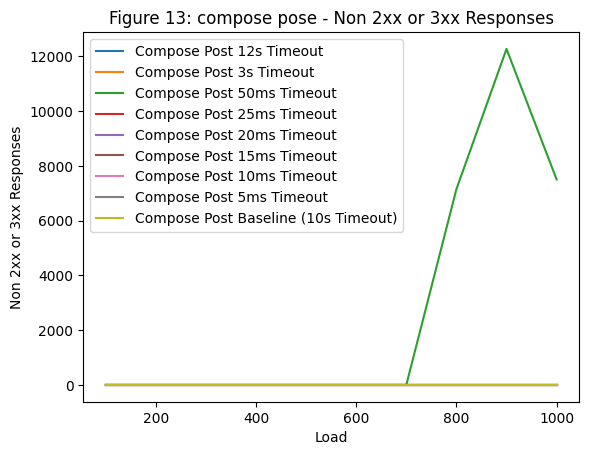

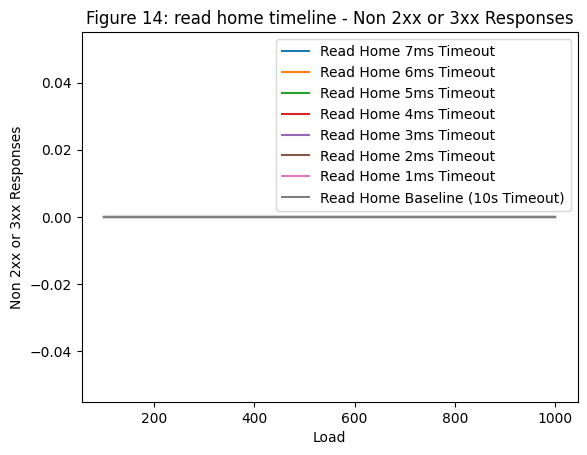

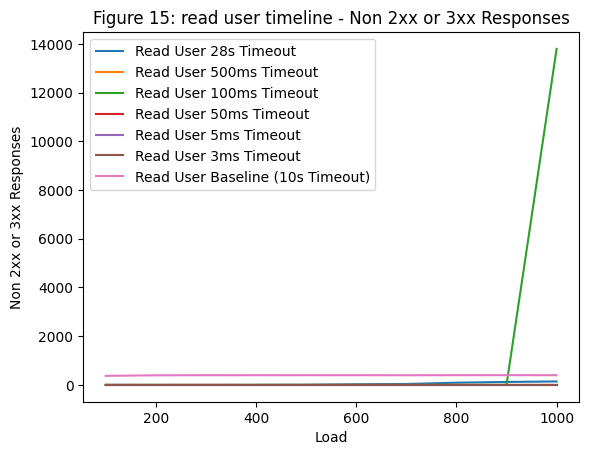

In [77]:
plot_gragh(load_range, [non_2xx_3xx_compose_3_12s_28s, non_2xx_3xx_compose_2_3s_100, non_2xx_3xx_compose_4_50_100, non_2xx_3xx_compose_3_25_28s, non_2xx_3xx_compose_1_20_500, non_2xx_3xx_compose_7_15_50, non_2xx_3xx_compose_6_10_3, non_2xx_3xx_compose_all_5ms, compose_base_non_2xx_3xx],
            ['Compose Post 12s Timeout', 'Compose Post 3s Timeout', 'Compose Post 50ms Timeout', 'Compose Post 25ms Timeout', 'Compose Post 20ms Timeout', 'Compose Post 15ms Timeout', 'Compose Post 10ms Timeout', 'Compose Post 5ms Timeout', 'Compose Post Baseline (10s Timeout)'],
            "Load", 'Non 2xx or 3xx Responses', 'Figure 13: compose pose - Non 2xx or 3xx Responses')
plot_gragh(load_range, [non_2xx_3xx_read_home_7_15_50, non_2xx_3xx_read_home_6_10_3, non_2xx_3xx_read_home_all_5ms, non_2xx_3xx_read_home_4_50_100, non_2xx_3xx_read_home_3_12s_28s, non_2xx_3xx_read_home_2_3s_100, non_2xx_3xx_read_home_1_20_500, read_home_base_non_2xx_3xx],
            ['Read Home 7ms Timeout', 'Read Home 6ms Timeout', 'Read Home 5ms Timeout', 'Read Home 4ms Timeout', 'Read Home 3ms Timeout', 'Read Home 2ms Timeout', 'Read Home 1ms Timeout', 'Read Home Baseline (10s Timeout)'],
            "Load", 'Non 2xx or 3xx Responses', 'Figure 14: read home timeline - Non 2xx or 3xx Responses')
plot_gragh(load_range, [non_2xx_3xx_read_user_3_12s_28s, non_2xx_3xx_read_user_1_20_500, non_2xx_3xx_read_user_4_50_100, non_2xx_3xx_read_user_7_15_50, non_2xx_3xx_read_user_all_5ms, non_2xx_3xx_read_user_6_10_3, read_user_base_non_2xx_3xx],
            ['Read User 28s Timeout', 'Read User 500ms Timeout', 'Read User 100ms Timeout', 'Read User 50ms Timeout', 'Read User 5ms Timeout', 'Read User 3ms Timeout', 'Read User Baseline (10s Timeout)'],
            "Load", 'Non 2xx or 3xx Responses', 'Figure 15: read user timeline - Non 2xx or 3xx Responses')
plt.show()

**Compare the difference beween no retry, full retry, and budgeted retry**

For each of the following, plot a graph showing side-by-side comparison of retry and no-retry
For each service and metrics:
1. all_5ms
2. 2_25_28
3. 4_50_100

Same for read home and read users

So in total there will be 3 services, 3 configurations, 5 metrics

That rounds to 45 graphs lmao wow no 

In [78]:
# Feel like a histogram of some kind would work? 
retry_home_3_compose_25_user_28s_latency_data, retry_home_3_compose_25_user_28s_max_latency_data, retry_home_3_compose_25_user_28s_timeout_data, retry_home_3_compose_25_user_28s_non_2xx_3xx_data = report_generation("retry_home_3_compose_25_user_28s")
retry_all_5ms_timeout_latency_data, retry_all_5ms_timeout_max_latency_data, retry_all_5ms_timeout_timeout_data, retry_all_5ms_timeout_non_2xx_3xx_data = report_generation("retry_all_5ms_timeout")
retry_home_4_compose_50_user_100_latency_data, retry_home_4_compose_50_user_100_max_latency_data, retry_home_4_compose_50_user_100_timeout_data, retry_home_4_compose_50_user_100_non_2xx_3xx_data = report_generation("retry_home_4_compose_50_user_100")
retry_home_3_compose_12s_user_28s_latency_data, retry_home_3_compose_12s_user_28s_max_latency_data, retry_home_3_compose_12s_user_28s_timeout_data, retry_home_3_compose_12s_user_28s_non_2xx_3xx_data = report_generation("retry_home_3_compose_12s_user_28s")
retry_home_1_compose_20_user_500_latency_data, retry_home_1_compose_20_user_500_max_latency_data, retry_home_1_compose_20_user_500_timeout_data, retry_home_1_compose_20_user_500_non_2xx_3xx_data = report_generation("retry_home_1_compose_20_user_500")
retry_home_2_compose_3s_user_100_latency_data, retry_home_2_compose_3s_user_100_max_latency_data, retry_home_2_compose_3s_user_100_timeout_data, retry_home_2_compose_3s_user_100_non_2xx_3xx_data = report_generation("retry_home_2_compose_3s_user_100")
retry_home_6_compose_10_user_3_latency_data, retry_home_6_compose_10_user_3_max_latency_data, retry_home_6_compose_10_user_3_timeout_data, retry_home_6_compose_10_user_3_non_2xx_3xx_data = report_generation("retry_home_6_compose_10_user_3")
retry_home_7_compose_15_user_50_latency_data, retry_home_7_compose_15_user_50_max_latency_data, retry_home_7_compose_15_user_50_timeout_data, retry_home_7_compose_15_user_50_non_2xx_3xx_data = report_generation("retry_home_7_compose_15_user_50")

For 99% Latency

<Figure size 1000x600 with 0 Axes>

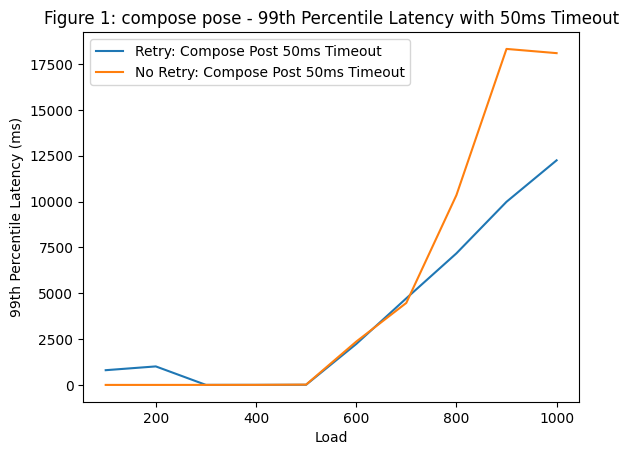

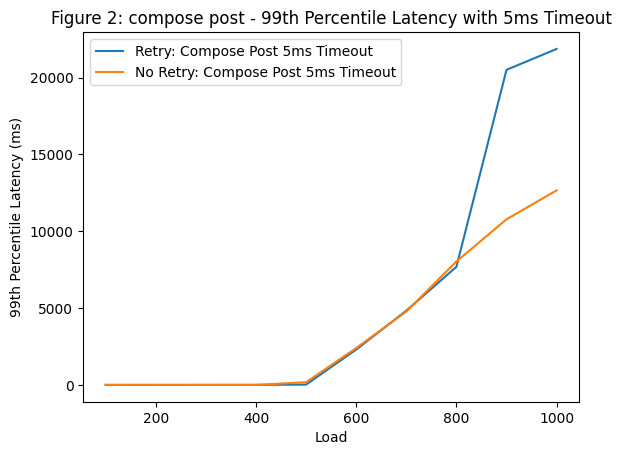

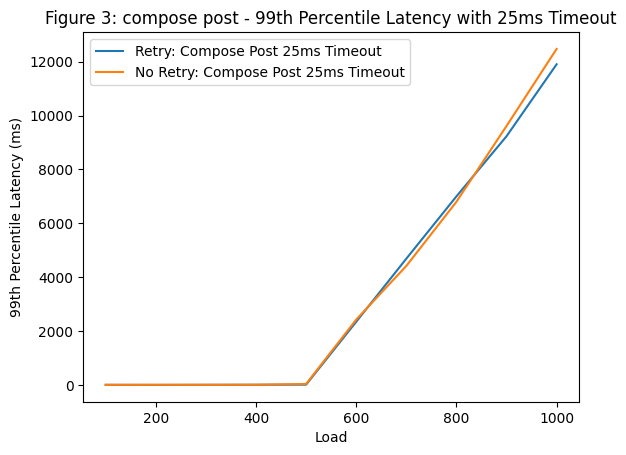

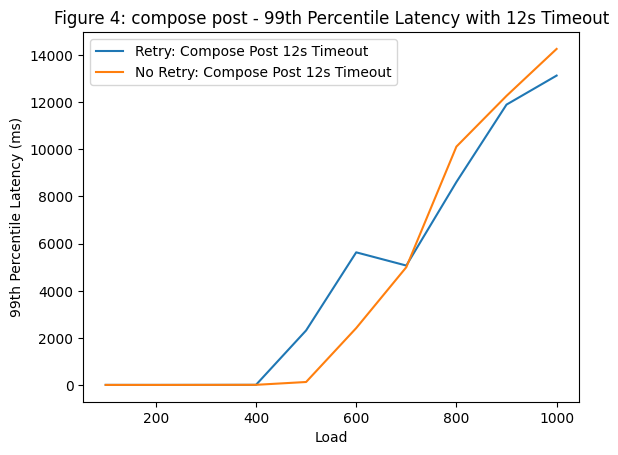

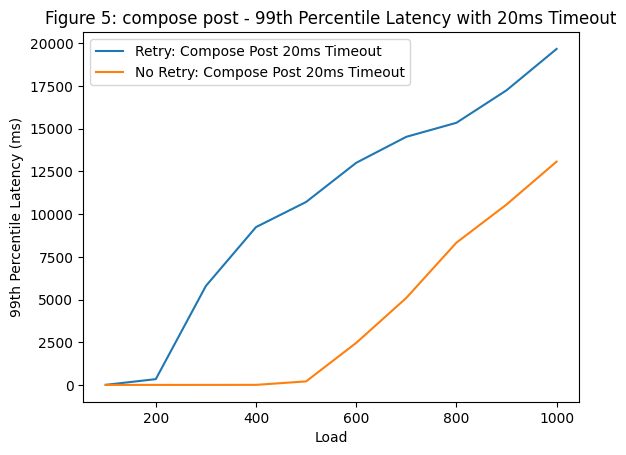

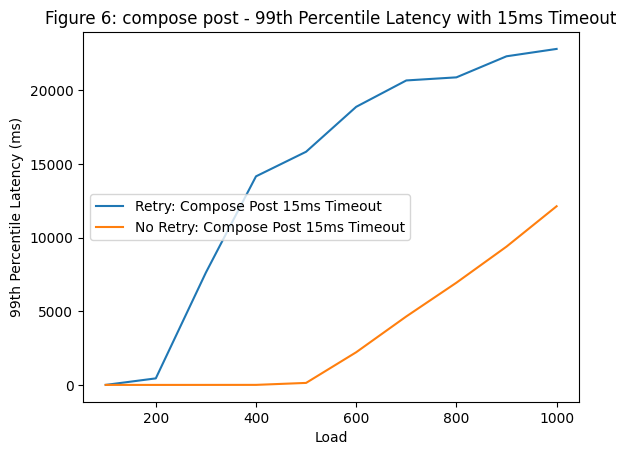

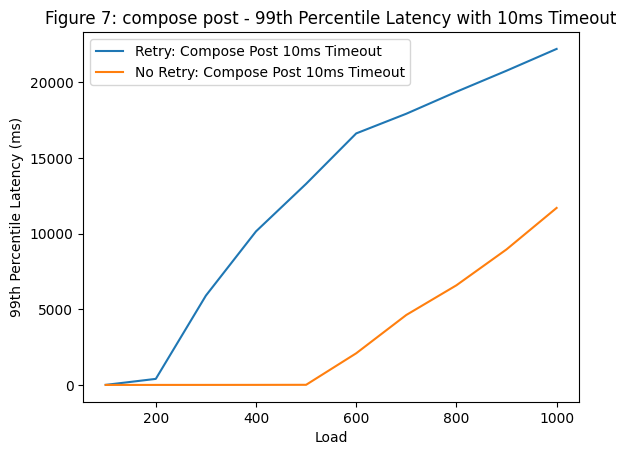

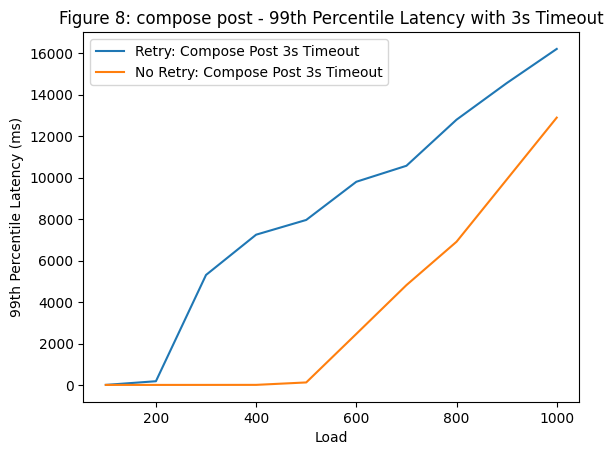

In [79]:
retry_latency_99th_compose_3_25_28s, retry_latency_99th_read_home_3_25_28s, retry_latency_99th_read_user_3_25_28s = get_all_99_latency(retry_home_3_compose_25_user_28s_latency_data)
retry_latency_99th_compose_all_5ms, retry_latency_99th_read_home_all_5ms, retry_latency_99th_read_user_all_5ms = get_all_99_latency(retry_all_5ms_timeout_latency_data)
retry_latency_99th_compose_4_50_100, retry_latency_99th_read_home_4_50_100, retry_latency_99th_read_user_4_50_100 = get_all_99_latency(retry_home_4_compose_50_user_100_latency_data)
retry_latency_99th_compose_3_12s_28s, retry_latency_99th_read_home_3_12s_28s, retry_latency_99th_read_user_3_12s_28s = get_all_99_latency(retry_home_3_compose_12s_user_28s_latency_data)
retry_latency_99th_compose_1_20_500, retry_latency_99th_read_home_1_20_500, retry_latency_99th_read_user_1_20_500 = get_all_99_latency(retry_home_1_compose_20_user_500_latency_data)
retry_latency_99th_compose_2_3s_100, retry_latency_99th_read_home_2_3s_100, retry_latency_99th_read_user_2_3s_100 = get_all_99_latency(retry_home_2_compose_3s_user_100_latency_data)
retry_latency_99th_compose_6_10_3, retry_latency_99th_read_home_6_10_3, retry_latency_99th_read_user_6_10_3 = get_all_99_latency(retry_home_6_compose_10_user_3_latency_data)
retry_latency_99th_compose_7_15_50, retry_latency_99th_read_home_7_15_50, retry_latency_99th_read_user_7_15_50 = get_all_99_latency(retry_home_7_compose_15_user_50_latency_data)

plt.figure(figsize=(10, 6))
plot_gragh(load_range, [retry_latency_99th_compose_4_50_100, latency_99th_compose_4_50_100],
              ['Retry: Compose Post 50ms Timeout', 'No Retry: Compose Post 50ms Timeout'],
              "Load", '99th Percentile Latency (ms)', 'Figure 1: compose pose - 99th Percentile Latency with 50ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_all_5ms, latency_99th_compose_all_5ms],
            ['Retry: Compose Post 5ms Timeout', 'No Retry: Compose Post 5ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 2: compose post - 99th Percentile Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_3_25_28s, latency_99th_compose_3_25_28s],
            ['Retry: Compose Post 25ms Timeout', 'No Retry: Compose Post 25ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 3: compose post - 99th Percentile Latency with 25ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_3_12s_28s, latency_99th_compose_3_12s_28s],
            ['Retry: Compose Post 12s Timeout', 'No Retry: Compose Post 12s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 4: compose post - 99th Percentile Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_1_20_500, latency_99th_compose_1_20_500],
            ['Retry: Compose Post 20ms Timeout', 'No Retry: Compose Post 20ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 5: compose post - 99th Percentile Latency with 20ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_7_15_50, latency_99th_compose_7_15_50],
            ['Retry: Compose Post 15ms Timeout', 'No Retry: Compose Post 15ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 6: compose post - 99th Percentile Latency with 15ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_6_10_3, latency_99th_compose_6_10_3],
            ['Retry: Compose Post 10ms Timeout', 'No Retry: Compose Post 10ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 7: compose post - 99th Percentile Latency with 10ms Timeout')
plot_gragh(load_range, [retry_latency_99th_compose_2_3s_100, latency_99th_compose_2_3s_100],
            ['Retry: Compose Post 3s Timeout', 'No Retry: Compose Post 3s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 8: compose post - 99th Percentile Latency with 3s Timeout')



Load:  [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Average 99th percentile latency of CP with retry: [112.85, 306.98, 3089.03, 5108.77, 6273.73, 8855.0, 10377.5, 12358.75, 15810.0, 17501.25]
Average 99th percentile latency of CP without retry: [11.82, 11.46, 12.49, 14.53, 113.3, 2362.5, 4736.25, 8010.0, 11223.75, 13408.75]
Average 99th percentile latency of RUT with retry: [21804.51, 20794.05, 20981.97, 20695.45, 20127.18, 20333.33, 24298.33, 25116.67, 24015.0, 26783.33]
Average 99th percentile latency of RUT without retry: [11266.25, 15707.41, 17045.23, 17539.73, 20387.14, 22175.0, 26055.0, 27110.0, 27746.67, 26195.0]
Average 99th percentile latency of RHT with retry: [2.4, 1.69, 1.69, 1.71, 1.71, 1.74, 1.78, 1.81, 1.85, 1.82]
Average 99th percentile latency of RHT without retry: [2.35, 1.72, 1.67, 1.69, 1.7, 1.73, 1.78, 1.78, 1.8, 1.86]


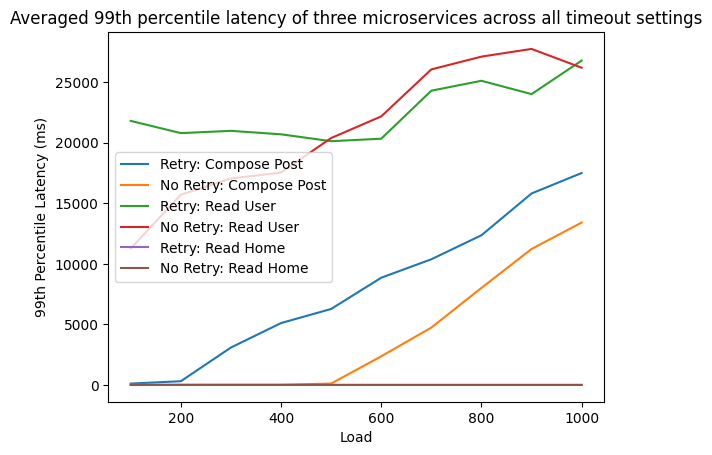

In [97]:
average_retry_latency_99th_compose = [round(sum(x)/len(x), 2) for x in zip(retry_latency_99th_compose_4_50_100, retry_latency_99th_compose_all_5ms, retry_latency_99th_compose_3_25_28s, retry_latency_99th_compose_3_12s_28s, retry_latency_99th_compose_1_20_500, retry_latency_99th_compose_7_15_50, retry_latency_99th_compose_6_10_3, retry_latency_99th_compose_2_3s_100)]
average_latency_99th_compose = [round(sum(x)/len(x), 2) for x in zip(latency_99th_compose_4_50_100, latency_99th_compose_all_5ms, latency_99th_compose_3_25_28s, latency_99th_compose_3_12s_28s, latency_99th_compose_1_20_500, latency_99th_compose_7_15_50, latency_99th_compose_6_10_3, latency_99th_compose_2_3s_100)]

average_retry_latency_99th_user = [round(sum(x)/len(x), 2) for x in zip(retry_latency_99th_read_user_3_25_28s, retry_latency_99th_read_user_3_12s_28s, retry_latency_99th_read_user_1_20_500, retry_latency_99th_read_user_7_15_50, retry_latency_99th_read_user_6_10_3, retry_latency_99th_read_user_2_3s_100)]
average_latency_99th_user = [round(sum(x)/len(x), 2) for x in zip(latency_99th_read_user_3_25_28s, latency_99th_read_user_3_12s_28s, latency_99th_read_user_1_20_500, latency_99th_read_user_7_15_50, latency_99th_read_user_6_10_3, latency_99th_read_user_2_3s_100)]

average_retry_latency_99th_home = [round(sum(x)/len(x), 2) for x in zip(retry_latency_99th_read_home_3_25_28s, retry_latency_99th_read_home_3_12s_28s, retry_latency_99th_read_home_1_20_500, retry_latency_99th_read_home_7_15_50, retry_latency_99th_read_home_6_10_3, retry_latency_99th_read_home_2_3s_100)]
average_latency_99th_home = [round(sum(x)/len(x), 2) for x in zip(latency_99th_read_home_3_25_28s, latency_99th_read_home_3_12s_28s, latency_99th_read_home_1_20_500, latency_99th_read_home_7_15_50, latency_99th_read_home_6_10_3, latency_99th_read_home_2_3s_100)]

plot_gragh(load_range, [average_retry_latency_99th_compose, average_latency_99th_compose, average_retry_latency_99th_user, average_latency_99th_user, average_retry_latency_99th_home, average_latency_99th_home],
            ['Retry: Compose Post', 'No Retry: Compose Post', 'Retry: Read User', 'No Retry: Read User', 'Retry: Read Home', 'No Retry: Read Home'],
            "Load", '99th Percentile Latency (ms)', 'Averaged 99th percentile latency of three microservices across all timeout settings')


print("Load: ", load_range)
print("Average 99th percentile latency of CP with retry: " + str(average_retry_latency_99th_compose))
print("Average 99th percentile latency of CP without retry: " + str(average_latency_99th_compose))
print("Average 99th percentile latency of RUT with retry: " + str(average_retry_latency_99th_user))
print("Average 99th percentile latency of RUT without retry: " + str(average_latency_99th_user))
print("Average 99th percentile latency of RHT with retry: " + str(average_retry_latency_99th_home))
print("Average 99th percentile latency of RHT without retry: " + str(average_latency_99th_home))


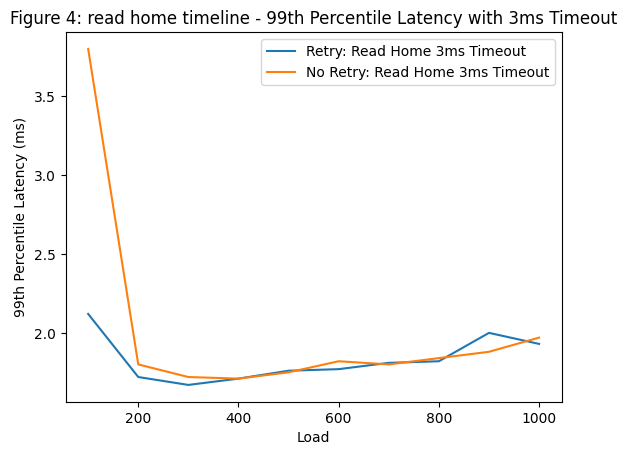

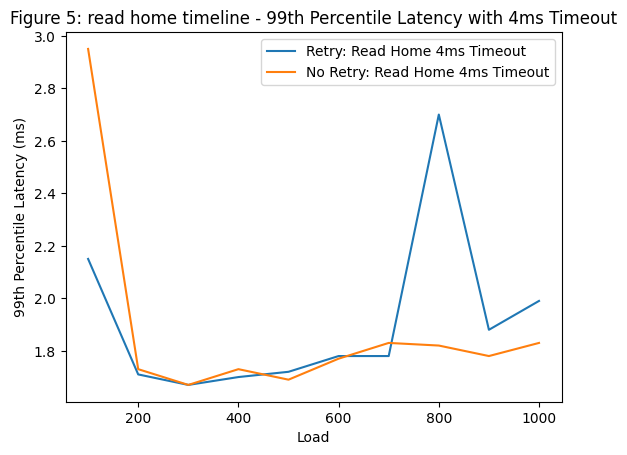

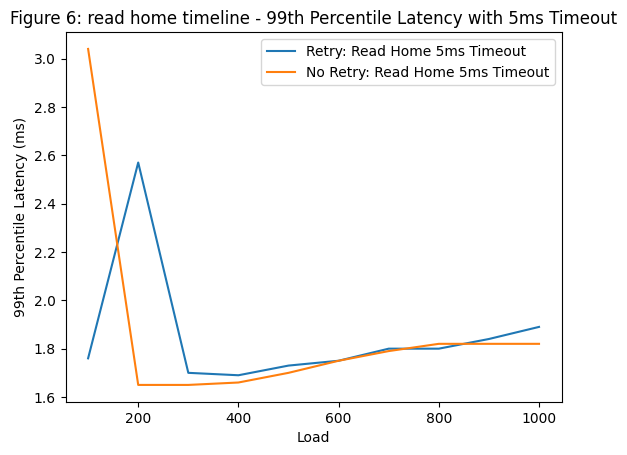

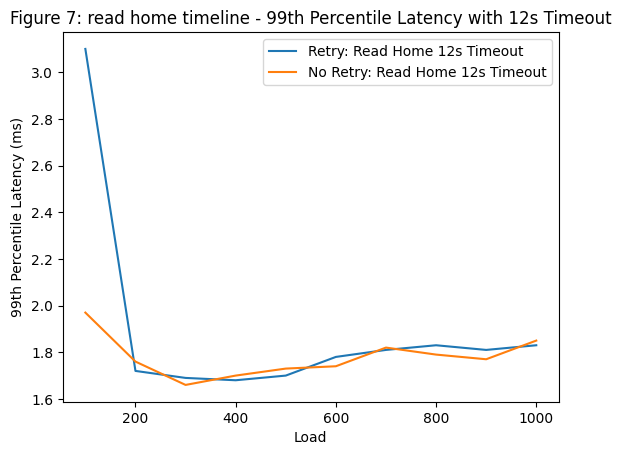

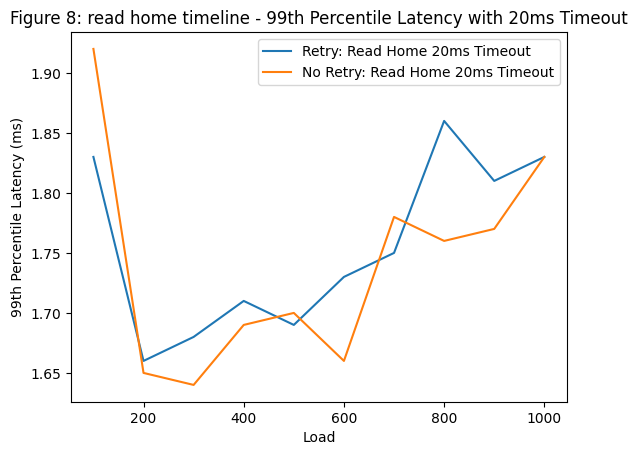

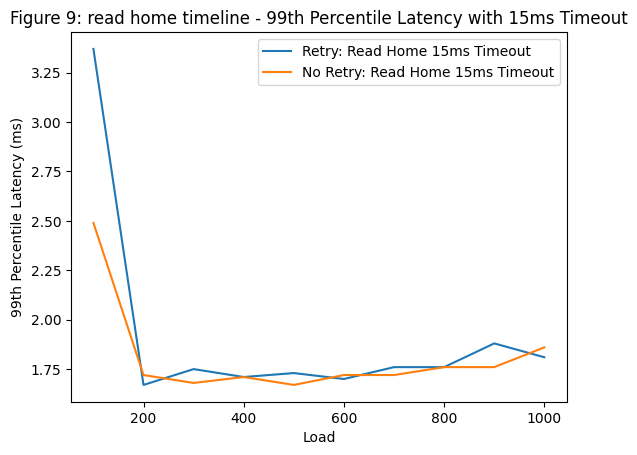

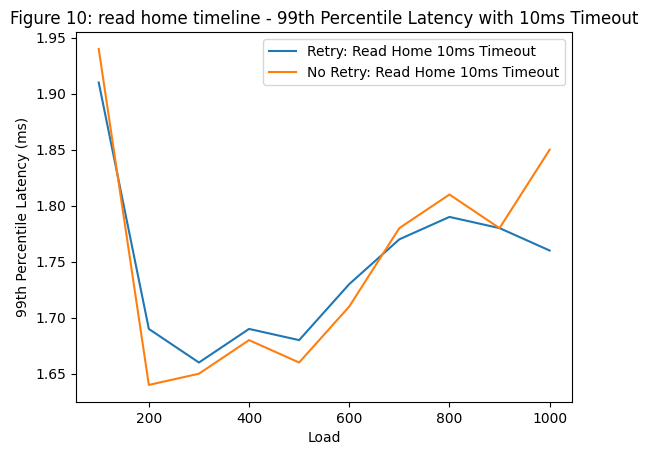

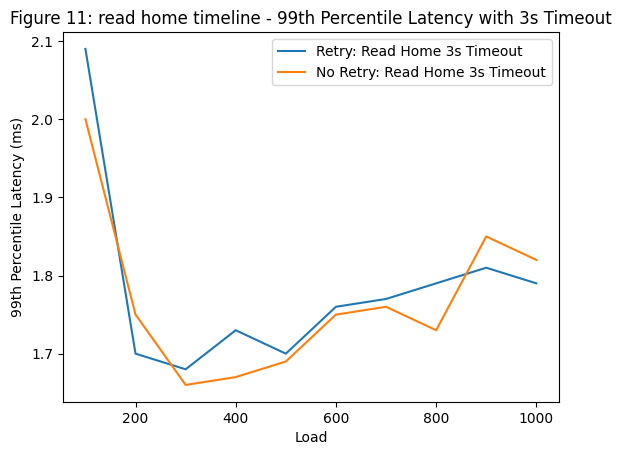

In [81]:
plot_gragh(load_range, [retry_latency_99th_read_home_3_25_28s, latency_99th_read_home_3_25_28s],
            ['Retry: Read Home 3ms Timeout', 'No Retry: Read Home 3ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 4: read home timeline - 99th Percentile Latency with 3ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_4_50_100, latency_99th_read_home_4_50_100],
            ['Retry: Read Home 4ms Timeout', 'No Retry: Read Home 4ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 5: read home timeline - 99th Percentile Latency with 4ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_all_5ms, latency_99th_read_home_all_5ms],
            ['Retry: Read Home 5ms Timeout', 'No Retry: Read Home 5ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 6: read home timeline - 99th Percentile Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_3_12s_28s, latency_99th_read_home_3_12s_28s],
            ['Retry: Read Home 12s Timeout', 'No Retry: Read Home 12s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 7: read home timeline - 99th Percentile Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_1_20_500, latency_99th_read_home_1_20_500],
            ['Retry: Read Home 20ms Timeout', 'No Retry: Read Home 20ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 8: read home timeline - 99th Percentile Latency with 20ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_7_15_50, latency_99th_read_home_7_15_50],
            ['Retry: Read Home 15ms Timeout', 'No Retry: Read Home 15ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 9: read home timeline - 99th Percentile Latency with 15ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_6_10_3, latency_99th_read_home_6_10_3],
            ['Retry: Read Home 10ms Timeout', 'No Retry: Read Home 10ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 10: read home timeline - 99th Percentile Latency with 10ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_home_2_3s_100, latency_99th_read_home_2_3s_100],
            ['Retry: Read Home 3s Timeout', 'No Retry: Read Home 3s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 11: read home timeline - 99th Percentile Latency with 3s Timeout')


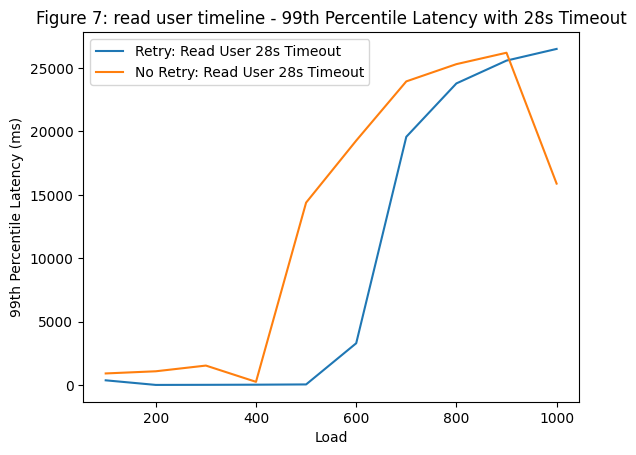

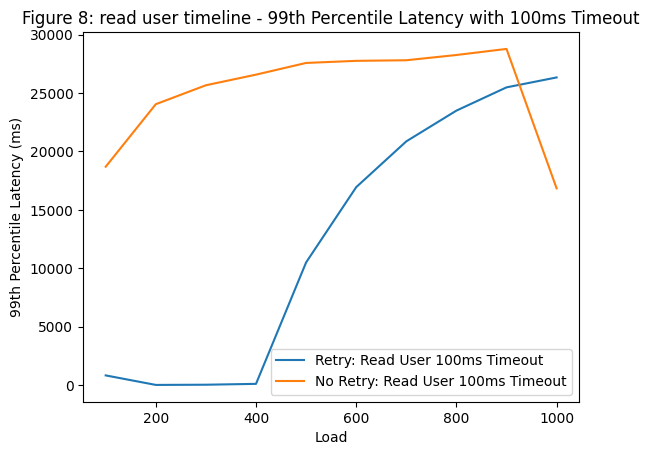

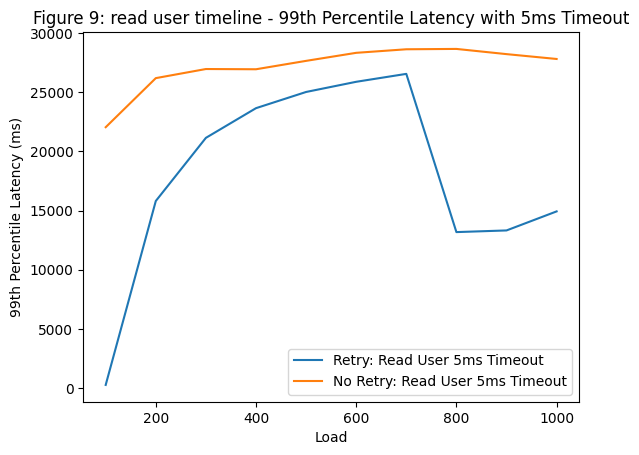

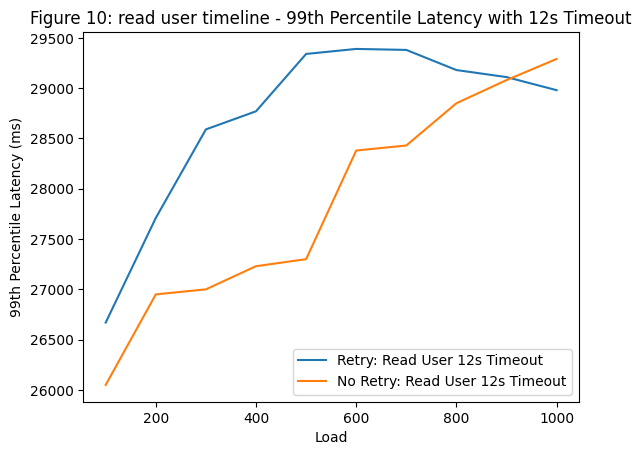

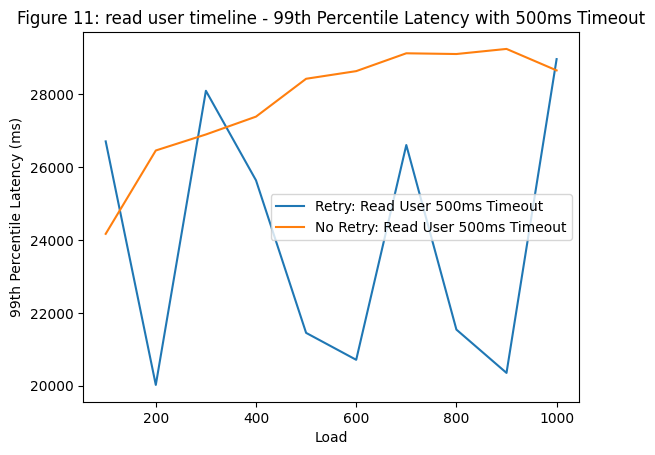

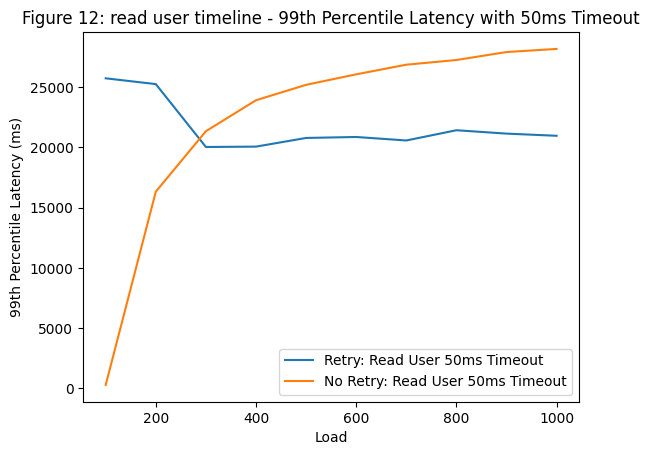

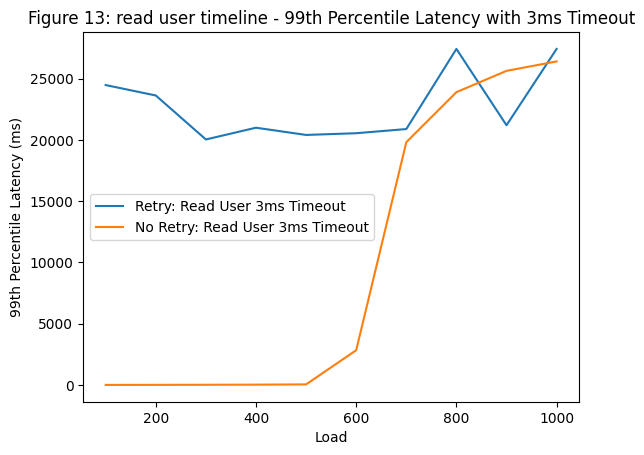

In [82]:
plot_gragh(load_range, [retry_latency_99th_read_user_3_25_28s, latency_99th_read_user_3_25_28s],
            ['Retry: Read User 28s Timeout', 'No Retry: Read User 28s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 7: read user timeline - 99th Percentile Latency with 28s Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_4_50_100, latency_99th_read_user_4_50_100],
            ['Retry: Read User 100ms Timeout', 'No Retry: Read User 100ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 8: read user timeline - 99th Percentile Latency with 100ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_all_5ms, latency_99th_read_user_all_5ms],
            ['Retry: Read User 5ms Timeout', 'No Retry: Read User 5ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 9: read user timeline - 99th Percentile Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_3_12s_28s, latency_99th_read_user_3_12s_28s],
            ['Retry: Read User 12s Timeout', 'No Retry: Read User 12s Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 10: read user timeline - 99th Percentile Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_1_20_500, latency_99th_read_user_1_20_500],
            ['Retry: Read User 500ms Timeout', 'No Retry: Read User 500ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 11: read user timeline - 99th Percentile Latency with 500ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_7_15_50, latency_99th_read_user_7_15_50],
            ['Retry: Read User 50ms Timeout', 'No Retry: Read User 50ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 12: read user timeline - 99th Percentile Latency with 50ms Timeout')
plot_gragh(load_range, [retry_latency_99th_read_user_6_10_3, latency_99th_read_user_6_10_3],
            ['Retry: Read User 3ms Timeout', 'No Retry: Read User 3ms Timeout'],
            "Load", '99th Percentile Latency (ms)', 'Figure 13: read user timeline - 99th Percentile Latency with 3ms Timeout')

For Mean Latency

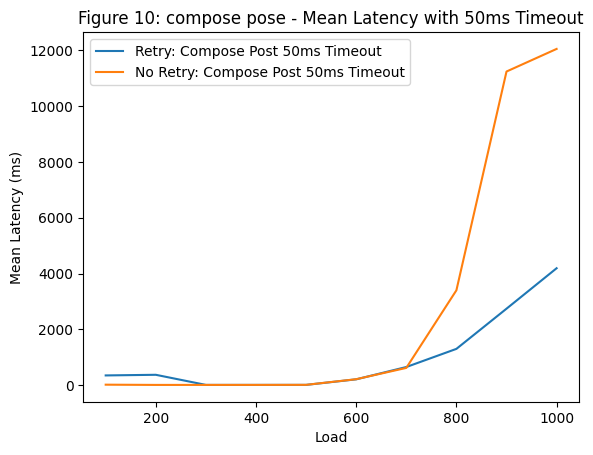

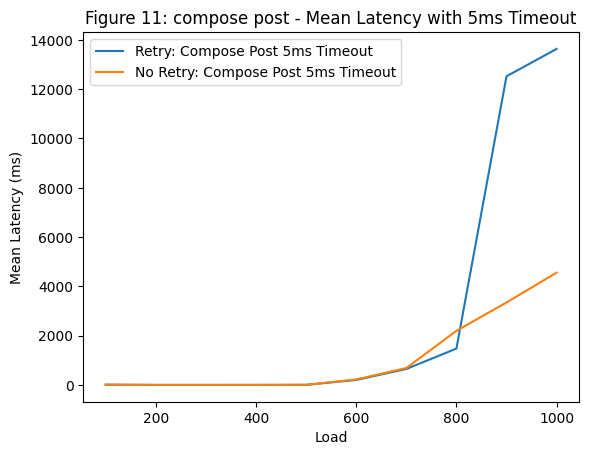

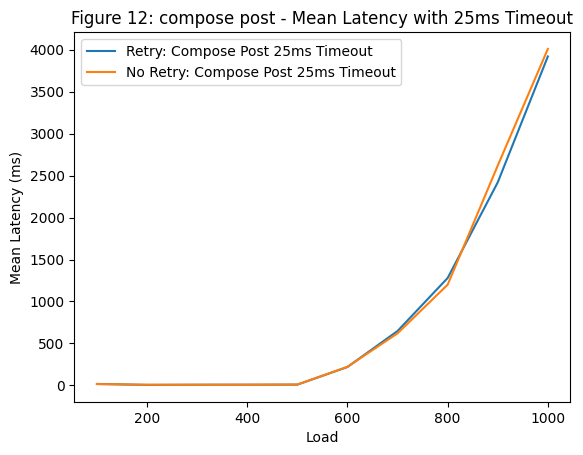

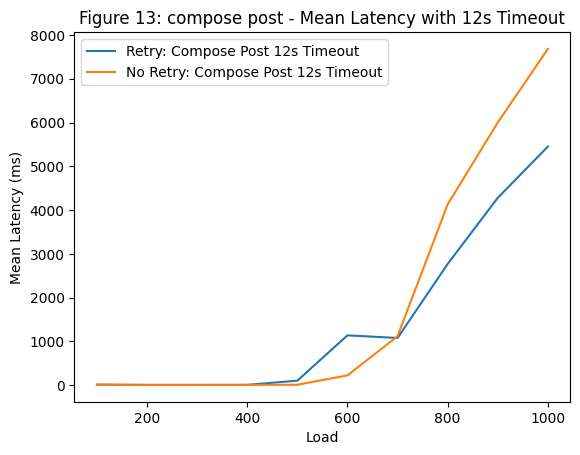

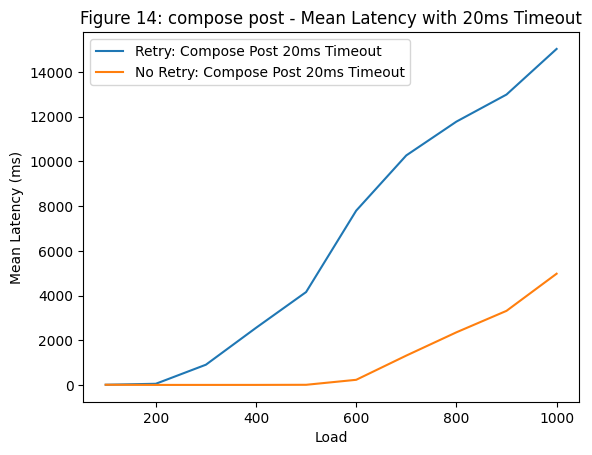

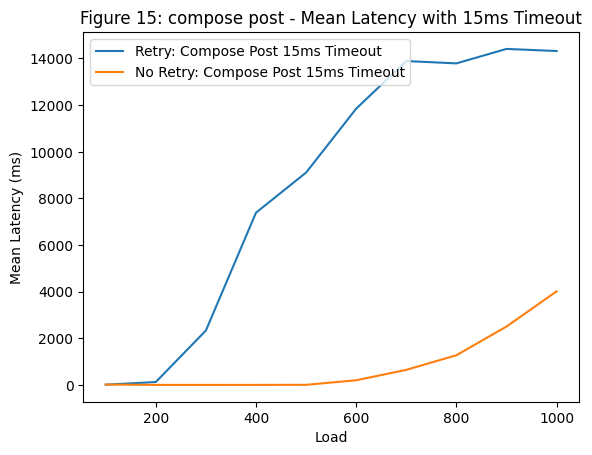

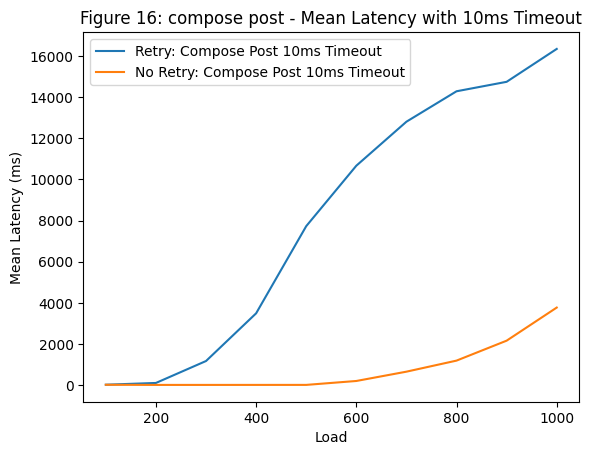

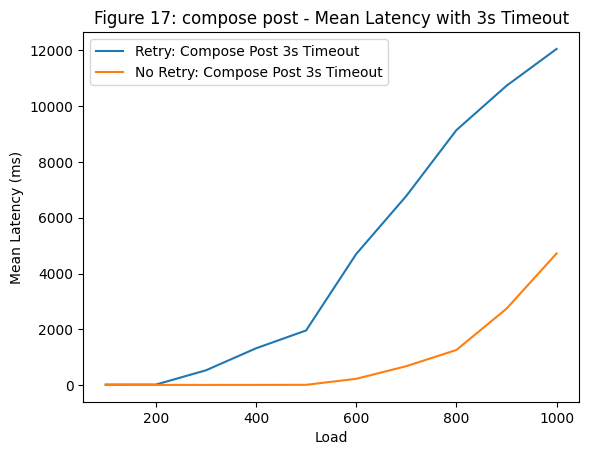

In [83]:
retry_latency_mean_compose_3_25_28s, retry_latency_mean_read_home_3_25_28s, retry_latency_mean_read_user_3_25_28s = get_all_mean_latency(retry_home_3_compose_25_user_28s_latency_data)
retry_latency_mean_compose_all_5ms, retry_latency_mean_read_home_all_5ms, retry_latency_mean_read_user_all_5ms = get_all_mean_latency(retry_all_5ms_timeout_latency_data)
retry_latency_mean_compose_4_50_100, retry_latency_mean_read_home_4_50_100, retry_latency_mean_read_user_4_50_100 = get_all_mean_latency(retry_home_4_compose_50_user_100_latency_data)
retry_latency_mean_compose_3_12s_28s, retry_latency_mean_read_home_3_12s_28s, retry_latency_mean_read_user_3_12s_28s = get_all_mean_latency(retry_home_3_compose_12s_user_28s_latency_data)
retry_latency_mean_compose_1_20_500, retry_latency_mean_read_home_1_20_500, retry_latency_mean_read_user_1_20_500 = get_all_mean_latency(retry_home_1_compose_20_user_500_latency_data)
retry_latency_mean_compose_2_3s_100, retry_latency_mean_read_home_2_3s_100, retry_latency_mean_read_user_2_3s_100 = get_all_mean_latency(retry_home_2_compose_3s_user_100_latency_data)
retry_latency_mean_compose_6_10_3, retry_latency_mean_read_home_6_10_3, retry_latency_mean_read_user_6_10_3 = get_all_mean_latency(retry_home_6_compose_10_user_3_latency_data)
retry_latency_mean_compose_7_15_50, retry_latency_mean_read_home_7_15_50, retry_latency_mean_read_user_7_15_50 = get_all_mean_latency(retry_home_7_compose_15_user_50_latency_data)

plot_gragh(load_range, [retry_latency_mean_compose_4_50_100, latency_mean_compose_4_50_100],
              ['Retry: Compose Post 50ms Timeout', 'No Retry: Compose Post 50ms Timeout'],
              "Load", 'Mean Latency (ms)', 'Figure 10: compose pose - Mean Latency with 50ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_all_5ms, latency_mean_compose_all_5ms],
            ['Retry: Compose Post 5ms Timeout', 'No Retry: Compose Post 5ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 11: compose post - Mean Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_3_25_28s, latency_mean_compose_3_25_28s],
            ['Retry: Compose Post 25ms Timeout', 'No Retry: Compose Post 25ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 12: compose post - Mean Latency with 25ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_3_12s_28s, latency_mean_compose_3_12s_28s],
            ['Retry: Compose Post 12s Timeout', 'No Retry: Compose Post 12s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 13: compose post - Mean Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_1_20_500, latency_mean_compose_1_20_500],
            ['Retry: Compose Post 20ms Timeout', 'No Retry: Compose Post 20ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 14: compose post - Mean Latency with 20ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_7_15_50, latency_mean_compose_7_15_50],
            ['Retry: Compose Post 15ms Timeout', 'No Retry: Compose Post 15ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 15: compose post - Mean Latency with 15ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_6_10_3, latency_mean_compose_6_10_3],
            ['Retry: Compose Post 10ms Timeout', 'No Retry: Compose Post 10ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 16: compose post - Mean Latency with 10ms Timeout')
plot_gragh(load_range, [retry_latency_mean_compose_2_3s_100, latency_mean_compose_2_3s_100],
            ['Retry: Compose Post 3s Timeout', 'No Retry: Compose Post 3s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 17: compose post - Mean Latency with 3s Timeout')


Load:  [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
Average retry latency mean compose:  [57.94, 88.37, 623.2, 1849.37, 2886.88, 4599.68, 5847.82, 6978.75, 9355.0, 10617.5]
Average latency mean compose:  [17.3, 7.84, 8.04, 8.5, 11.38, 219.78, 794.7, 2127.5, 4242.5, 5723.75]
Average retry latency mean user:  [12358.54, 12738.86, 13244.1, 13161.24, 13278.46, 13061.39, 14820.0, 15400.0, 15580.0, 15748.33]
Average latency mean user:  [6092.05, 9347.38, 10781.16, 11576.52, 13306.76, 14541.63, 17230.0, 17935.0, 18593.33, 17146.67]
Average retry latency mean home:  [10.15, 1.27, 1.25, 1.23, 1.22, 1.21, 1.2, 1.18, 1.18, 1.15]
Average latency mean home:  [9.8, 1.29, 1.26, 1.24, 1.22, 1.21, 1.2, 1.18, 1.17, 1.17]


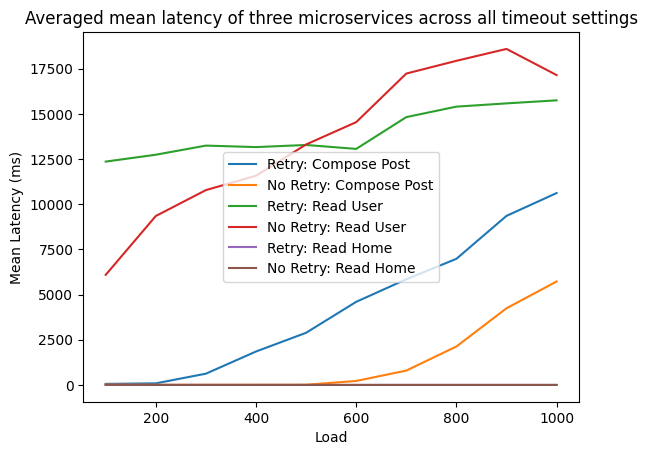

In [95]:
average_retry_latency_mean_compose = [round(sum(x)/len(x), 2) for x in zip(retry_latency_mean_compose_4_50_100, retry_latency_mean_compose_all_5ms, retry_latency_mean_compose_3_25_28s, retry_latency_mean_compose_3_12s_28s, retry_latency_mean_compose_1_20_500, retry_latency_mean_compose_7_15_50, retry_latency_mean_compose_6_10_3, retry_latency_mean_compose_2_3s_100)]
average_latency_mean_compose = [round(sum(x)/len(x), 2) for x in zip(latency_mean_compose_4_50_100, latency_mean_compose_all_5ms, latency_mean_compose_3_25_28s, latency_mean_compose_3_12s_28s, latency_mean_compose_1_20_500, latency_mean_compose_7_15_50, latency_mean_compose_6_10_3, latency_mean_compose_2_3s_100)]

average_retry_latency_mean_user = [round(sum(x)/len(x), 2) for x in zip(retry_latency_mean_read_user_3_25_28s, retry_latency_mean_read_user_3_12s_28s, retry_latency_mean_read_user_1_20_500, retry_latency_mean_read_user_7_15_50, retry_latency_mean_read_user_6_10_3, retry_latency_mean_read_user_2_3s_100)]
average_latency_mean_user = [round(sum(x)/len(x), 2) for x in zip(latency_mean_read_user_3_25_28s, latency_mean_read_user_3_12s_28s, latency_mean_read_user_1_20_500, latency_mean_read_user_7_15_50, latency_mean_read_user_6_10_3, latency_mean_read_user_2_3s_100)]

average_retry_latency_mean_home = [round(sum(x)/len(x), 2) for x in zip(retry_latency_mean_read_home_3_25_28s, retry_latency_mean_read_home_3_12s_28s, retry_latency_mean_read_home_1_20_500, retry_latency_mean_read_home_7_15_50, retry_latency_mean_read_home_6_10_3, retry_latency_mean_read_home_2_3s_100)]
average_latency_mean_home = [round(sum(x)/len(x), 2) for x in zip(latency_mean_read_home_3_25_28s, latency_mean_read_home_3_12s_28s, latency_mean_read_home_1_20_500, latency_mean_read_home_7_15_50, latency_mean_read_home_6_10_3, latency_mean_read_home_2_3s_100)]

plot_gragh(load_range, [average_retry_latency_mean_compose, average_latency_mean_compose, average_retry_latency_mean_user, average_latency_mean_user, average_retry_latency_mean_home, average_latency_mean_home],
            ['Retry: Compose Post', 'No Retry: Compose Post', 'Retry: Read User', 'No Retry: Read User', 'Retry: Read Home', 'No Retry: Read Home'],
            "Load", 'Mean Latency (ms)', 'Averaged mean latency of three microservices across all timeout settings')

print("Load: ", load_range)
print("Average retry latency mean compose: ", average_retry_latency_mean_compose)
print("Average latency mean compose: ", average_latency_mean_compose)
print("Average retry latency mean user: ", average_retry_latency_mean_user)
print("Average latency mean user: ", average_latency_mean_user)
print("Average retry latency mean home: ", average_retry_latency_mean_home)
print("Average latency mean home: ", average_latency_mean_home)



In [ ]:
average_retry_latency_99th_compose

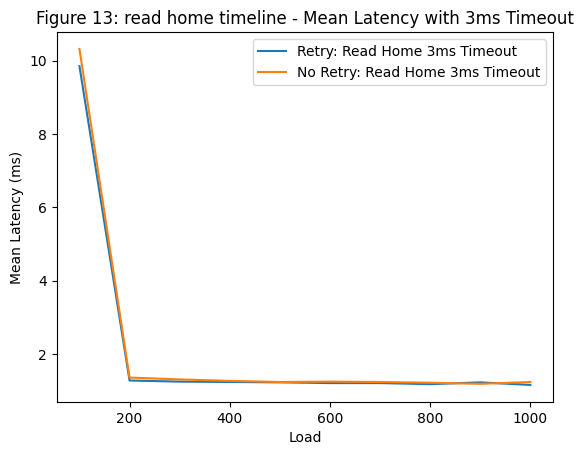

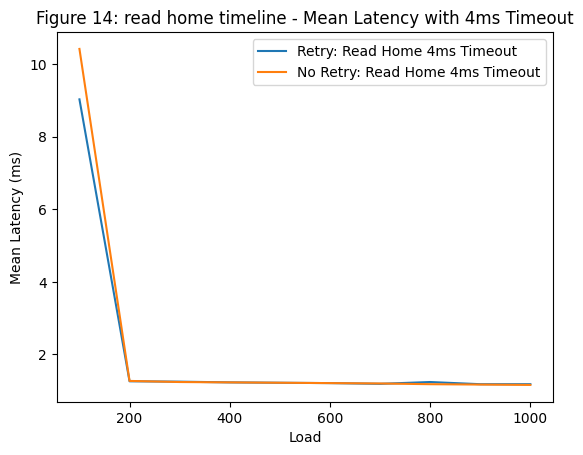

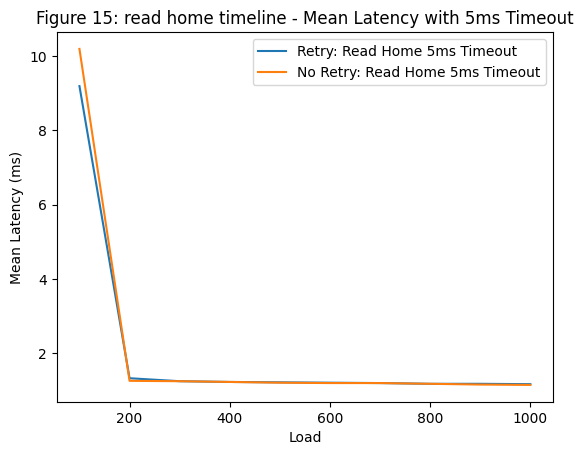

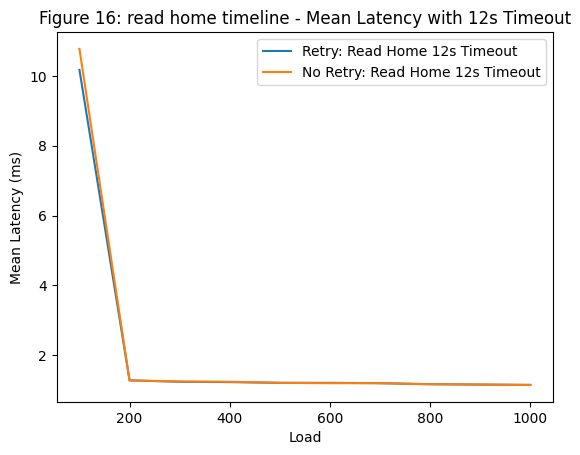

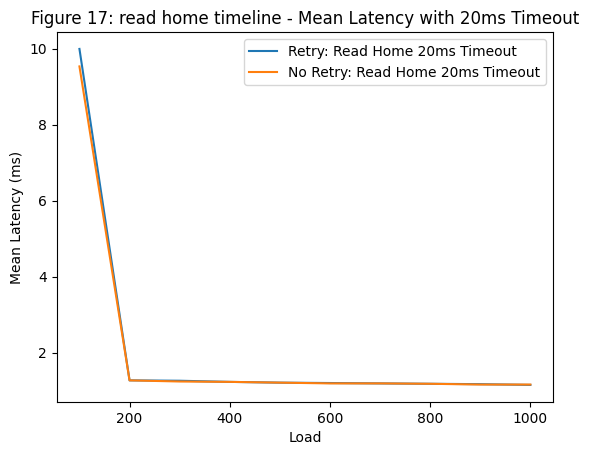

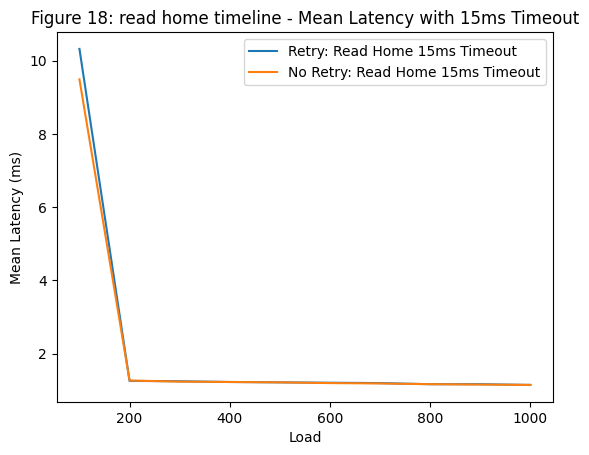

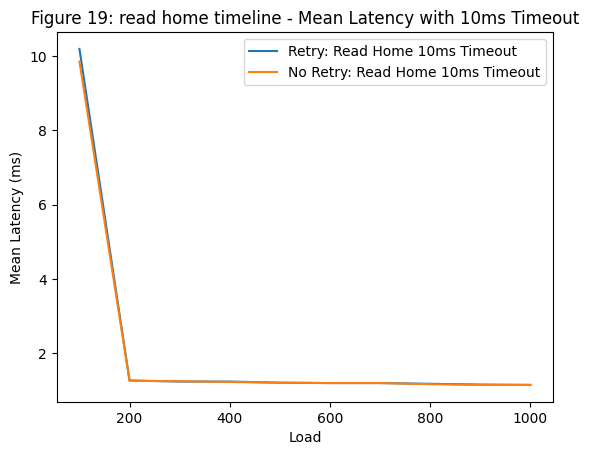

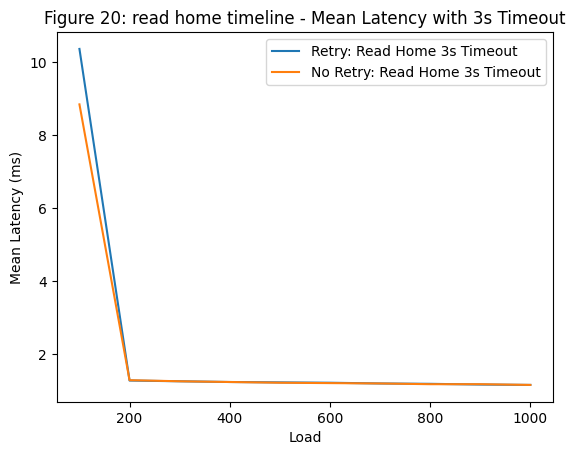

In [85]:
plot_gragh(load_range, [retry_latency_mean_read_home_3_25_28s, latency_mean_read_home_3_25_28s],
            ['Retry: Read Home 3ms Timeout', 'No Retry: Read Home 3ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 13: read home timeline - Mean Latency with 3ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_4_50_100, latency_mean_read_home_4_50_100],
            ['Retry: Read Home 4ms Timeout', 'No Retry: Read Home 4ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 14: read home timeline - Mean Latency with 4ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_all_5ms, latency_mean_read_home_all_5ms],
            ['Retry: Read Home 5ms Timeout', 'No Retry: Read Home 5ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 15: read home timeline - Mean Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_3_12s_28s, latency_mean_read_home_3_12s_28s],
            ['Retry: Read Home 12s Timeout', 'No Retry: Read Home 12s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 16: read home timeline - Mean Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_1_20_500, latency_mean_read_home_1_20_500],
            ['Retry: Read Home 20ms Timeout', 'No Retry: Read Home 20ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 17: read home timeline - Mean Latency with 20ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_7_15_50, latency_mean_read_home_7_15_50],
            ['Retry: Read Home 15ms Timeout', 'No Retry: Read Home 15ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 18: read home timeline - Mean Latency with 15ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_6_10_3, latency_mean_read_home_6_10_3],
            ['Retry: Read Home 10ms Timeout', 'No Retry: Read Home 10ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 19: read home timeline - Mean Latency with 10ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_home_2_3s_100, latency_mean_read_home_2_3s_100],
            ['Retry: Read Home 3s Timeout', 'No Retry: Read Home 3s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 20: read home timeline - Mean Latency with 3s Timeout')

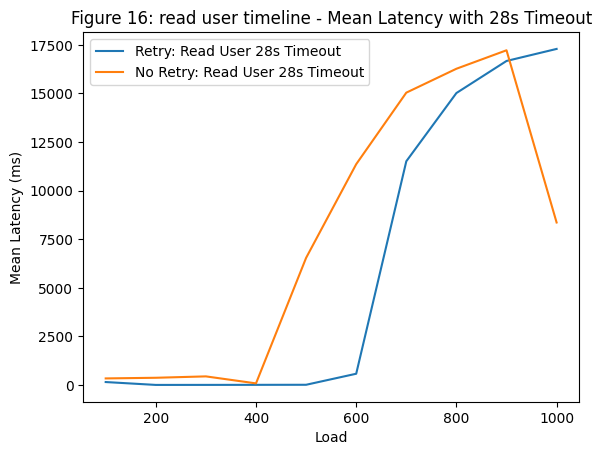

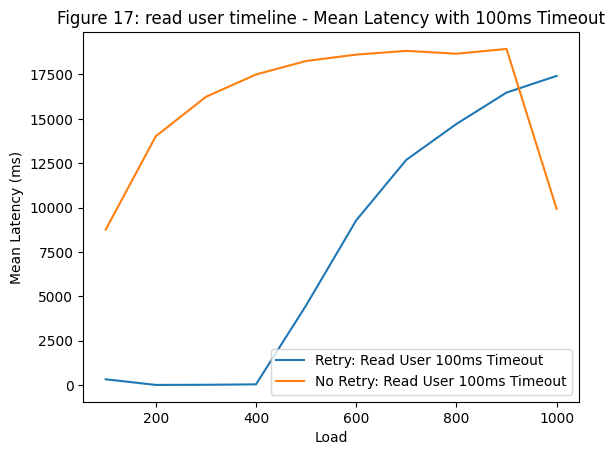

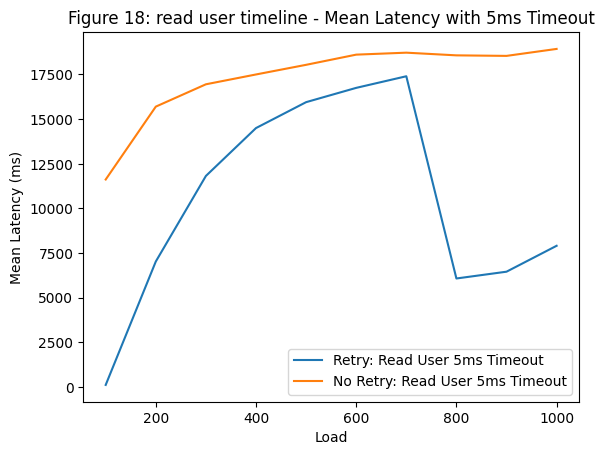

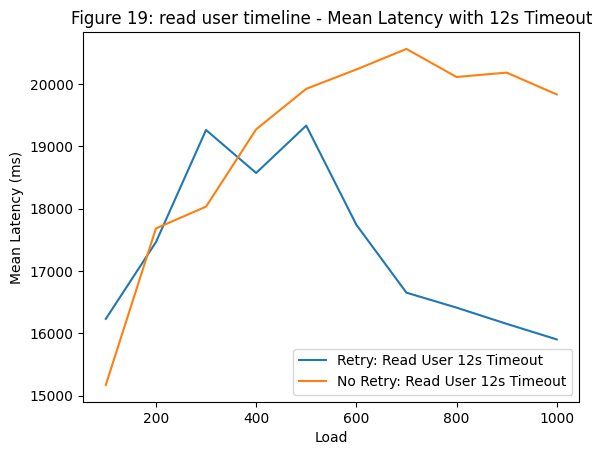

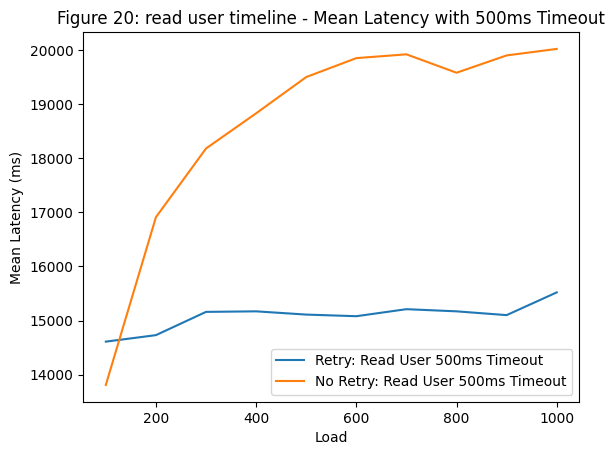

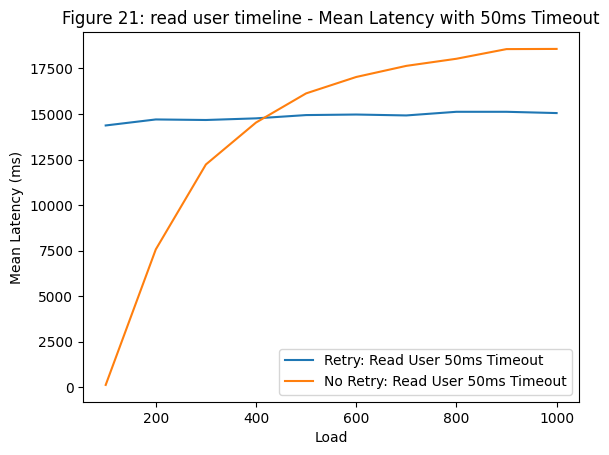

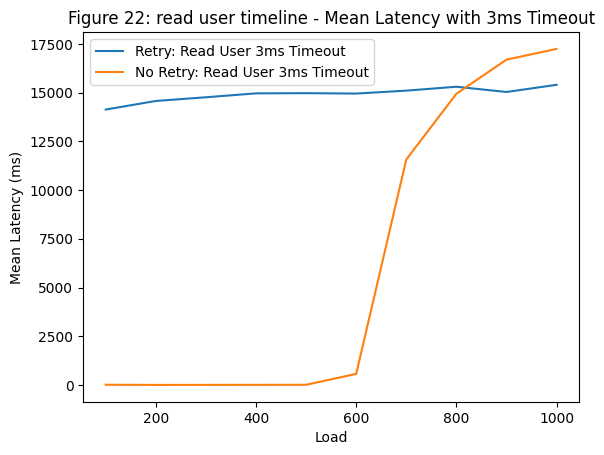

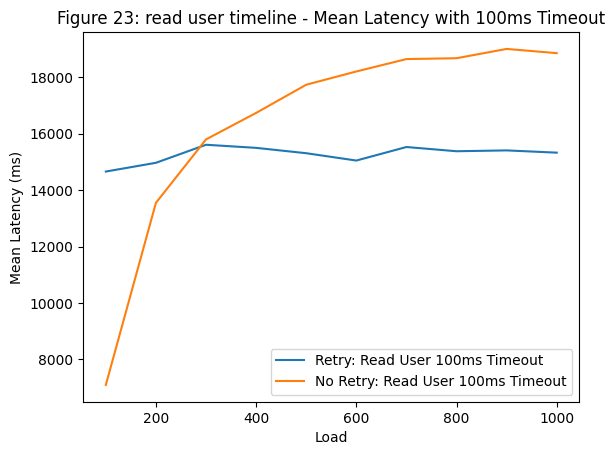

In [86]:
plot_gragh(load_range, [retry_latency_mean_read_user_3_25_28s, latency_mean_read_user_3_25_28s],
            ['Retry: Read User 28s Timeout', 'No Retry: Read User 28s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 16: read user timeline - Mean Latency with 28s Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_4_50_100, latency_mean_read_user_4_50_100],
            ['Retry: Read User 100ms Timeout', 'No Retry: Read User 100ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 17: read user timeline - Mean Latency with 100ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_all_5ms, latency_mean_read_user_all_5ms],
            ['Retry: Read User 5ms Timeout', 'No Retry: Read User 5ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 18: read user timeline - Mean Latency with 5ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_3_12s_28s, latency_mean_read_user_3_12s_28s],
            ['Retry: Read User 12s Timeout', 'No Retry: Read User 12s Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 19: read user timeline - Mean Latency with 12s Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_1_20_500, latency_mean_read_user_1_20_500],
            ['Retry: Read User 500ms Timeout', 'No Retry: Read User 500ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 20: read user timeline - Mean Latency with 500ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_7_15_50, latency_mean_read_user_7_15_50],
            ['Retry: Read User 50ms Timeout', 'No Retry: Read User 50ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 21: read user timeline - Mean Latency with 50ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_6_10_3, latency_mean_read_user_6_10_3],
            ['Retry: Read User 3ms Timeout', 'No Retry: Read User 3ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 22: read user timeline - Mean Latency with 3ms Timeout')
plot_gragh(load_range, [retry_latency_mean_read_user_2_3s_100, latency_mean_read_user_2_3s_100],
            ['Retry: Read User 100ms Timeout', 'No Retry: Read User 100ms Timeout'],
            "Load", 'Mean Latency (ms)', 'Figure 23: read user timeline - Mean Latency with 100ms Timeout')

For Number of Timeouts

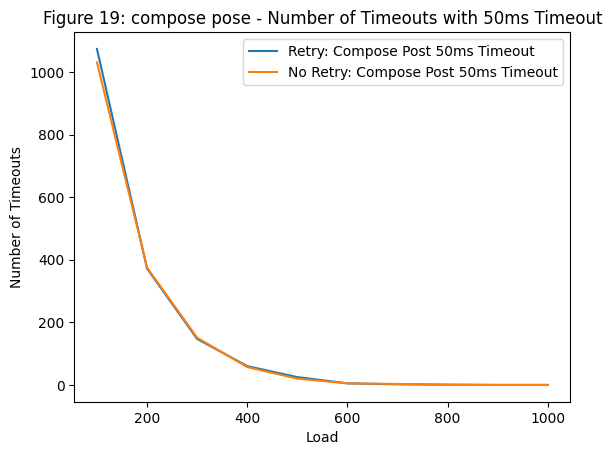

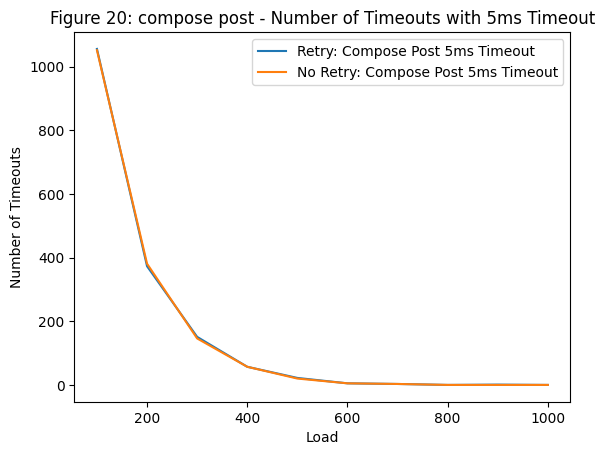

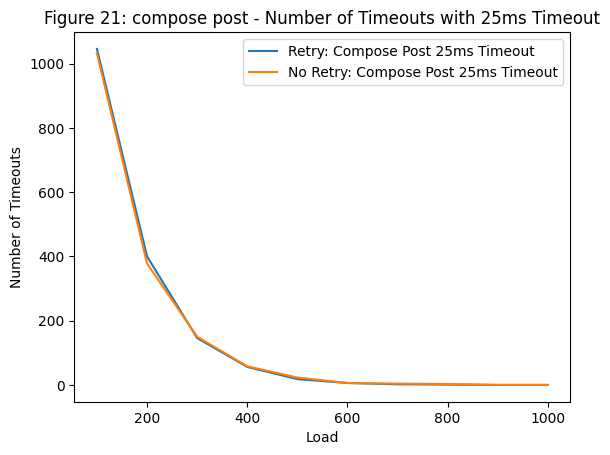

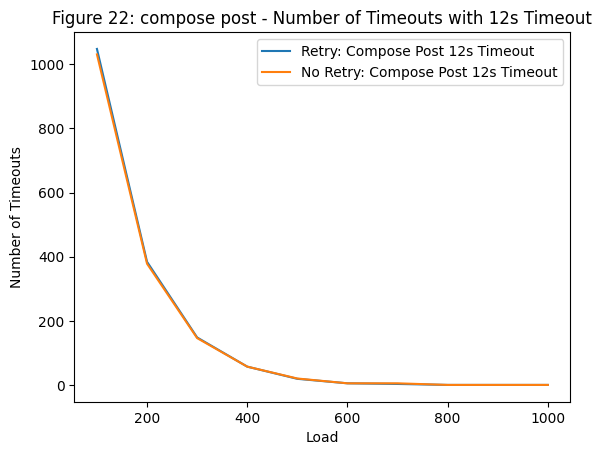

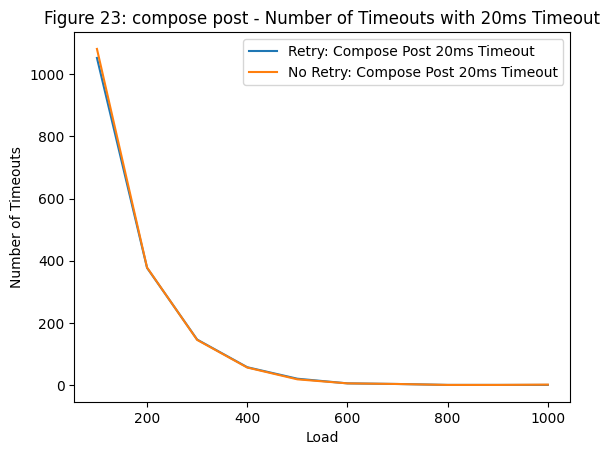

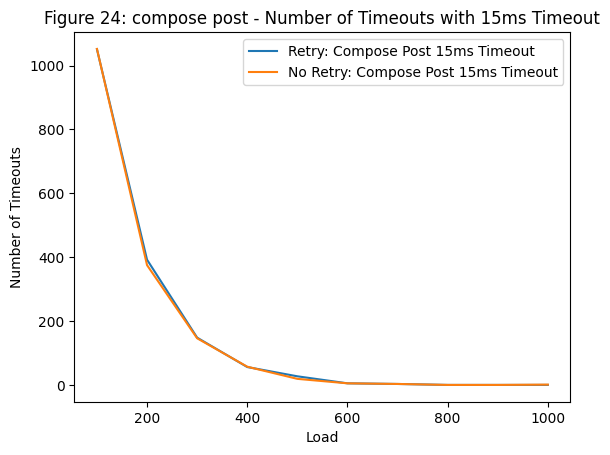

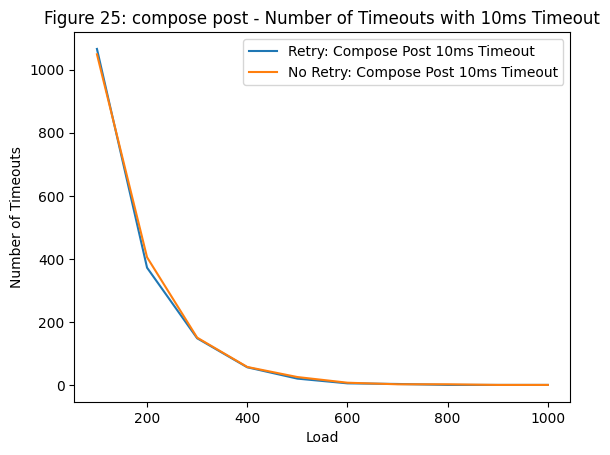

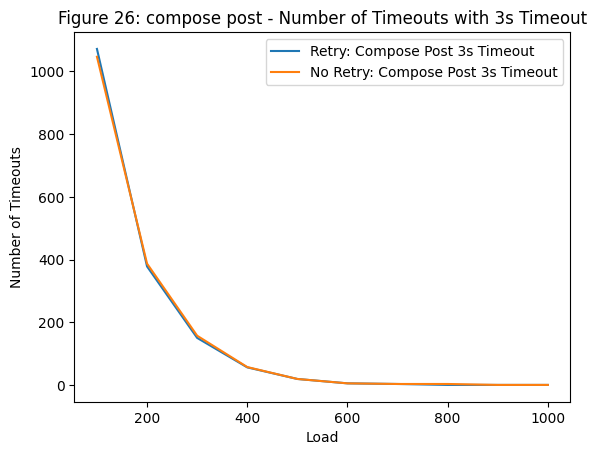

In [87]:
retry_timeout_compose_3_25_28s, retry_timeout_read_home_3_25_28s, retry_timeout_read_user_3_25_28s = get_all_data(retry_home_3_compose_25_user_28s_timeout_data)
retry_timeout_compose_all_5ms, retry_timeout_read_home_all_5ms, retry_timeout_read_user_all_5ms = get_all_data(retry_all_5ms_timeout_timeout_data)
retry_timeout_compose_4_50_100, retry_timeout_read_home_4_50_100, retry_timeout_read_user_4_50_100 = get_all_data(retry_home_4_compose_50_user_100_timeout_data)
retry_timeout_compose_3_12s_28s, retry_timeout_read_home_3_12s_28s, retry_timeout_read_user_3_12s_28s = get_all_data(retry_home_3_compose_12s_user_28s_timeout_data)
retry_timeout_compose_1_20_500, retry_timeout_read_home_1_20_500, retry_timeout_read_user_1_20_500 = get_all_data(retry_home_1_compose_20_user_500_timeout_data)
retry_timeout_compose_2_3s_100, retry_timeout_read_home_2_3s_100, retry_timeout_read_user_2_3s_100 = get_all_data(retry_home_2_compose_3s_user_100_timeout_data)
retry_timeout_compose_6_10_3, retry_timeout_read_home_6_10_3, retry_timeout_read_user_6_10_3 = get_all_data(retry_home_6_compose_10_user_3_timeout_data)
retry_timeout_compose_7_15_50, retry_timeout_read_home_7_15_50, retry_timeout_read_user_7_15_50 = get_all_data(retry_home_7_compose_15_user_50_timeout_data)

plot_gragh(load_range, [retry_timeout_compose_4_50_100, timeout_compose_4_50_100],
                ['Retry: Compose Post 50ms Timeout', 'No Retry: Compose Post 50ms Timeout'],
                "Load", 'Number of Timeouts', 'Figure 19: compose pose - Number of Timeouts with 50ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_all_5ms, timeout_compose_all_5ms],
            ['Retry: Compose Post 5ms Timeout', 'No Retry: Compose Post 5ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 20: compose post - Number of Timeouts with 5ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_3_25_28s, timeout_compose_3_25_28s],
            ['Retry: Compose Post 25ms Timeout', 'No Retry: Compose Post 25ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 21: compose post - Number of Timeouts with 25ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_3_12s_28s, timeout_compose_3_12s_28s],
            ['Retry: Compose Post 12s Timeout', 'No Retry: Compose Post 12s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 22: compose post - Number of Timeouts with 12s Timeout')
plot_gragh(load_range, [retry_timeout_compose_1_20_500, timeout_compose_1_20_500],
            ['Retry: Compose Post 20ms Timeout', 'No Retry: Compose Post 20ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 23: compose post - Number of Timeouts with 20ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_7_15_50, timeout_compose_7_15_50],
            ['Retry: Compose Post 15ms Timeout', 'No Retry: Compose Post 15ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 24: compose post - Number of Timeouts with 15ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_6_10_3, timeout_compose_6_10_3],
            ['Retry: Compose Post 10ms Timeout', 'No Retry: Compose Post 10ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 25: compose post - Number of Timeouts with 10ms Timeout')
plot_gragh(load_range, [retry_timeout_compose_2_3s_100, timeout_compose_2_3s_100],
            ['Retry: Compose Post 3s Timeout', 'No Retry: Compose Post 3s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 26: compose post - Number of Timeouts with 3s Timeout')


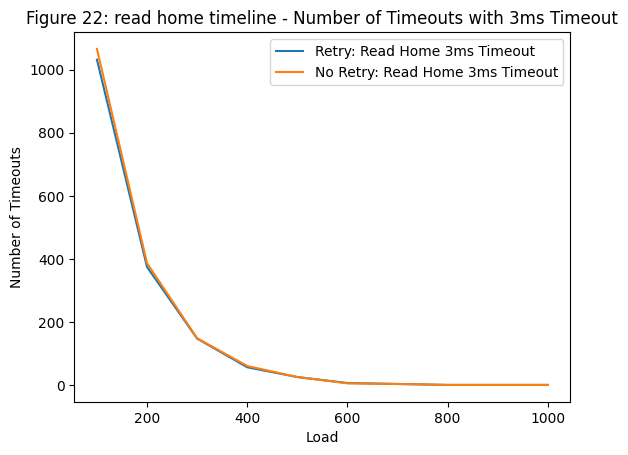

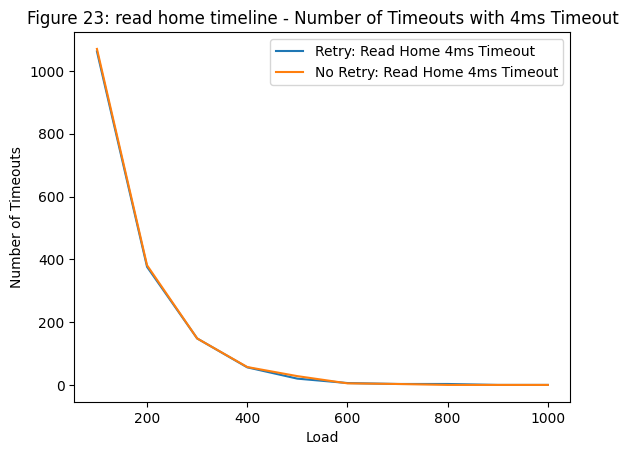

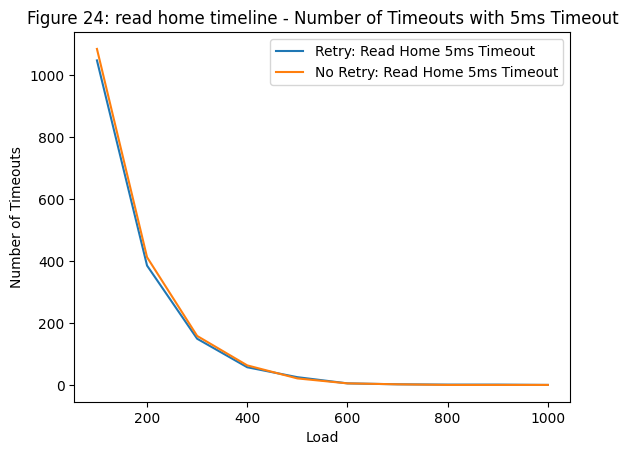

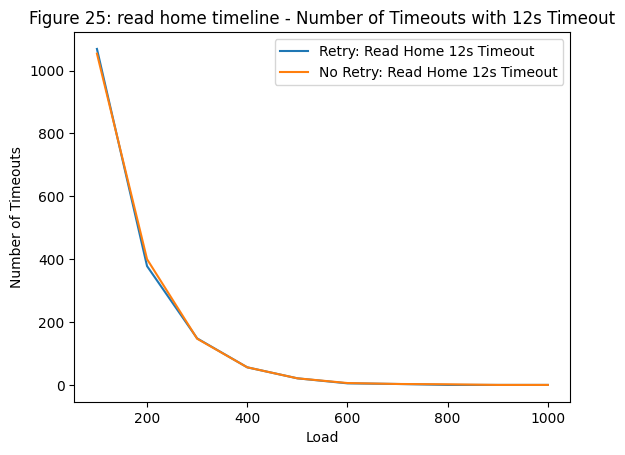

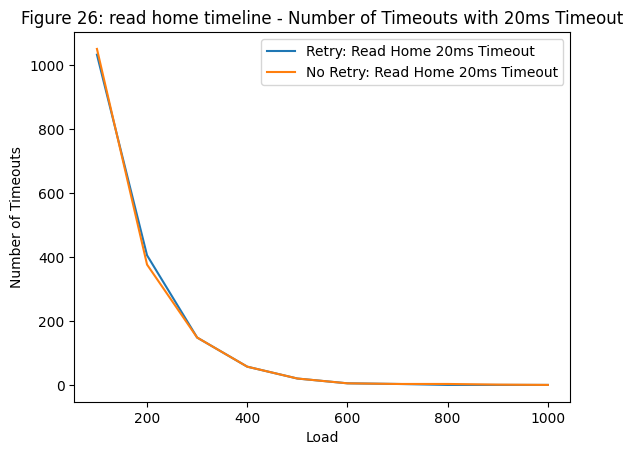

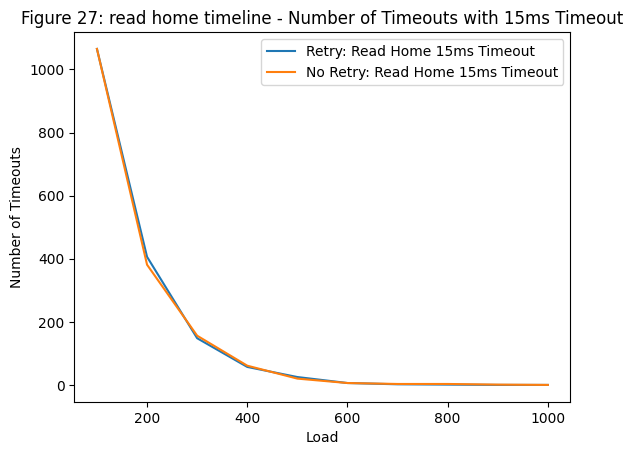

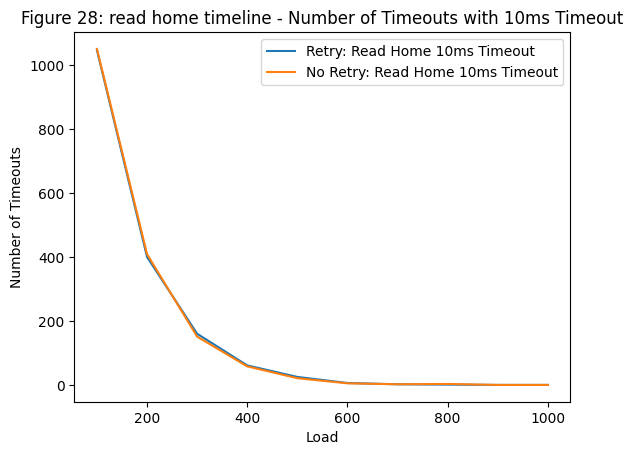

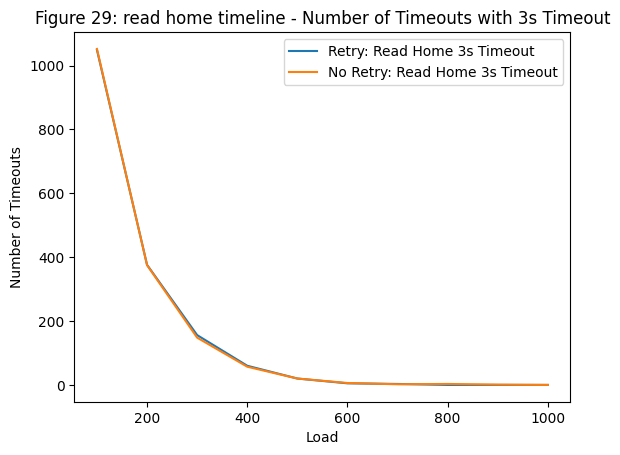

In [88]:
plot_gragh(load_range, [retry_timeout_read_home_3_25_28s, timeout_read_home_3_25_28s],
            ['Retry: Read Home 3ms Timeout', 'No Retry: Read Home 3ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 22: read home timeline - Number of Timeouts with 3ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_4_50_100, timeout_read_home_4_50_100],
            ['Retry: Read Home 4ms Timeout', 'No Retry: Read Home 4ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 23: read home timeline - Number of Timeouts with 4ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_all_5ms, timeout_read_home_all_5ms],
            ['Retry: Read Home 5ms Timeout', 'No Retry: Read Home 5ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 24: read home timeline - Number of Timeouts with 5ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_3_12s_28s, timeout_read_home_3_12s_28s],
            ['Retry: Read Home 12s Timeout', 'No Retry: Read Home 12s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 25: read home timeline - Number of Timeouts with 12s Timeout')
plot_gragh(load_range, [retry_timeout_read_home_1_20_500, timeout_read_home_1_20_500],
            ['Retry: Read Home 20ms Timeout', 'No Retry: Read Home 20ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 26: read home timeline - Number of Timeouts with 20ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_7_15_50, timeout_read_home_7_15_50],
            ['Retry: Read Home 15ms Timeout', 'No Retry: Read Home 15ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 27: read home timeline - Number of Timeouts with 15ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_6_10_3, timeout_read_home_6_10_3],
            ['Retry: Read Home 10ms Timeout', 'No Retry: Read Home 10ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 28: read home timeline - Number of Timeouts with 10ms Timeout')
plot_gragh(load_range, [retry_timeout_read_home_2_3s_100, timeout_read_home_2_3s_100],
            ['Retry: Read Home 3s Timeout', 'No Retry: Read Home 3s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 29: read home timeline - Number of Timeouts with 3s Timeout')


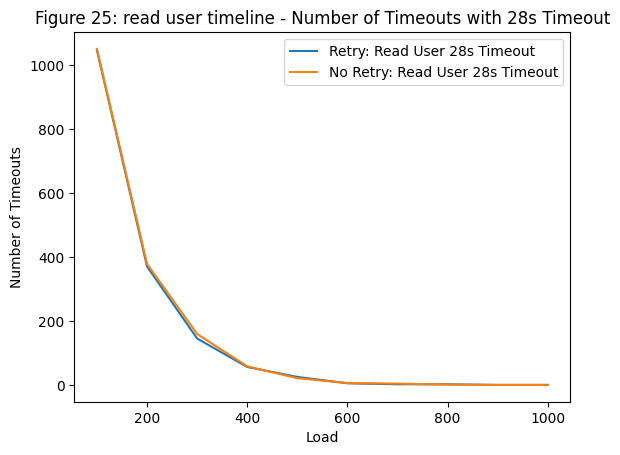

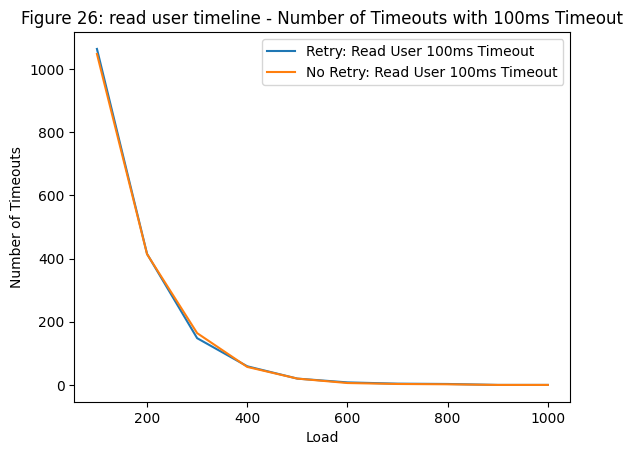

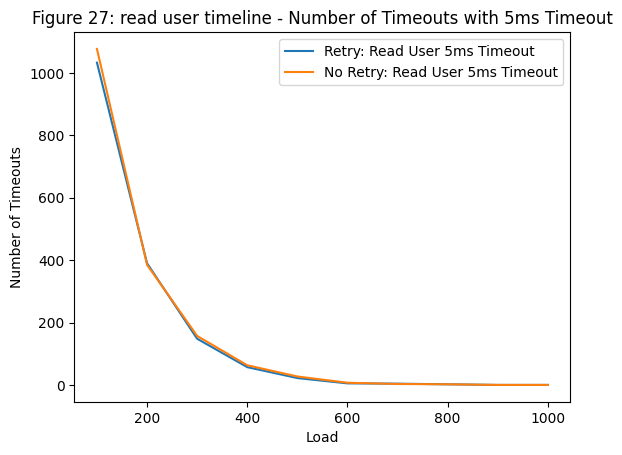

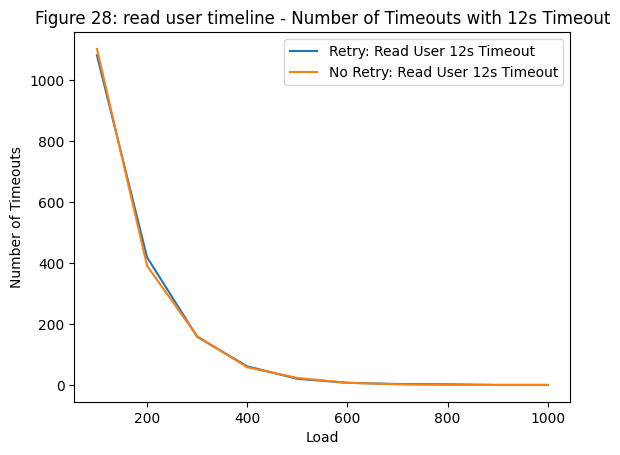

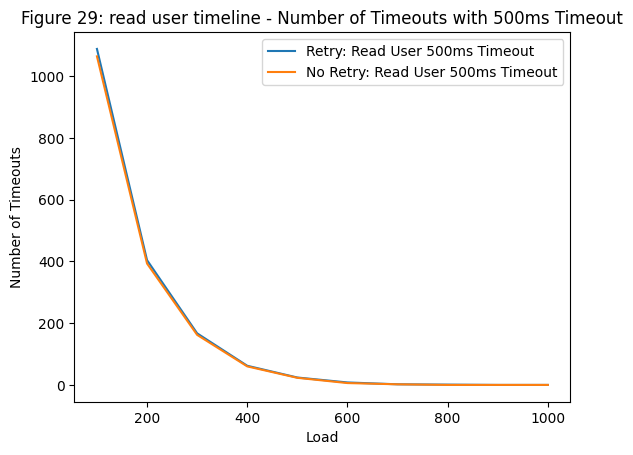

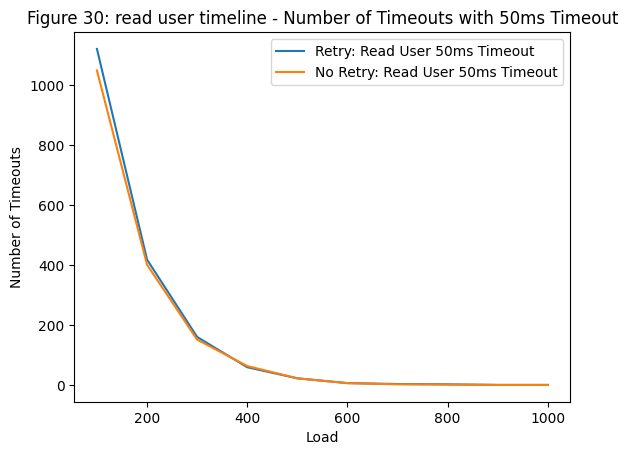

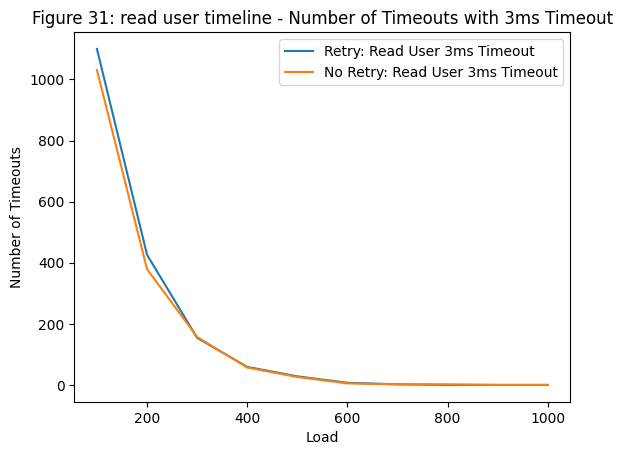

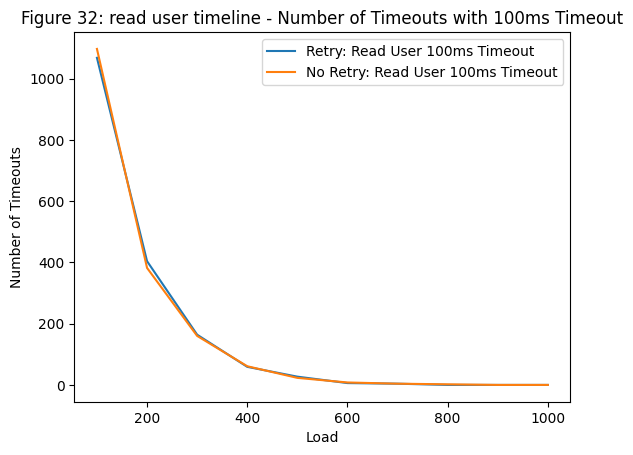

In [89]:
plot_gragh(load_range, [retry_timeout_read_user_3_25_28s, timeout_read_user_3_25_28s],
            ['Retry: Read User 28s Timeout', 'No Retry: Read User 28s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 25: read user timeline - Number of Timeouts with 28s Timeout')
plot_gragh(load_range, [retry_timeout_read_user_4_50_100, timeout_read_user_4_50_100],
            ['Retry: Read User 100ms Timeout', 'No Retry: Read User 100ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 26: read user timeline - Number of Timeouts with 100ms Timeout')
plot_gragh(load_range, [retry_timeout_read_user_all_5ms, timeout_read_user_all_5ms],
            ['Retry: Read User 5ms Timeout', 'No Retry: Read User 5ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 27: read user timeline - Number of Timeouts with 5ms Timeout')
plot_gragh(load_range, [retry_timeout_read_user_3_12s_28s, timeout_read_user_3_12s_28s],
            ['Retry: Read User 12s Timeout', 'No Retry: Read User 12s Timeout'],
            "Load", 'Number of Timeouts', 'Figure 28: read user timeline - Number of Timeouts with 12s Timeout')
plot_gragh(load_range, [retry_timeout_read_user_1_20_500, timeout_read_user_1_20_500],
            ['Retry: Read User 500ms Timeout', 'No Retry: Read User 500ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 29: read user timeline - Number of Timeouts with 500ms Timeout')
plot_gragh(load_range, [retry_timeout_read_user_7_15_50, timeout_read_user_7_15_50],
            ['Retry: Read User 50ms Timeout', 'No Retry: Read User 50ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 30: read user timeline - Number of Timeouts with 50ms Timeout')
plot_gragh(load_range, [retry_timeout_read_user_6_10_3, timeout_read_user_6_10_3],
            ['Retry: Read User 3ms Timeout', 'No Retry: Read User 3ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 31: read user timeline - Number of Timeouts with 3ms Timeout')
plot_gragh(load_range, [retry_timeout_read_user_2_3s_100, timeout_read_user_2_3s_100],
            ['Retry: Read User 100ms Timeout', 'No Retry: Read User 100ms Timeout'],
            "Load", 'Number of Timeouts', 'Figure 32: read user timeline - Number of Timeouts with 100ms Timeout')

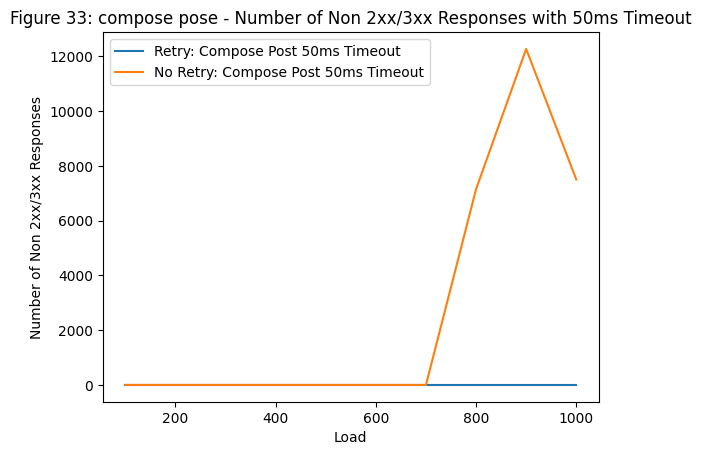

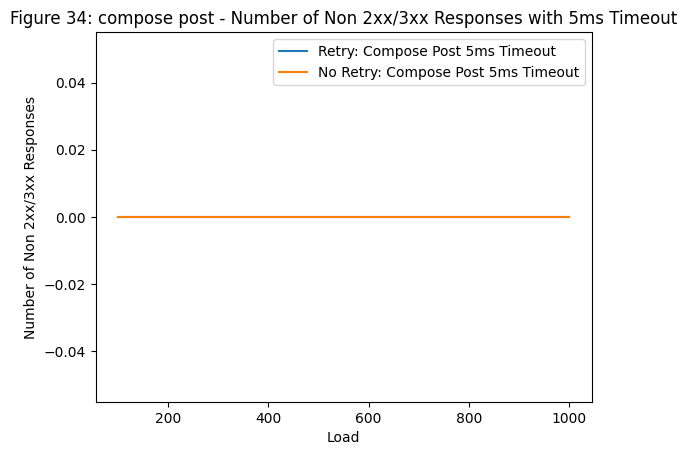

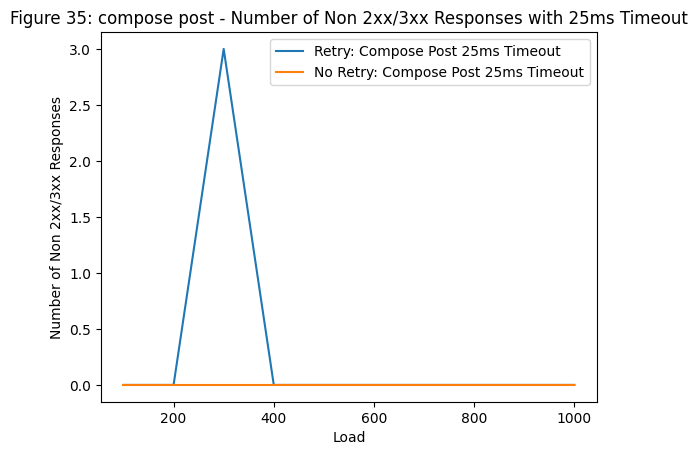

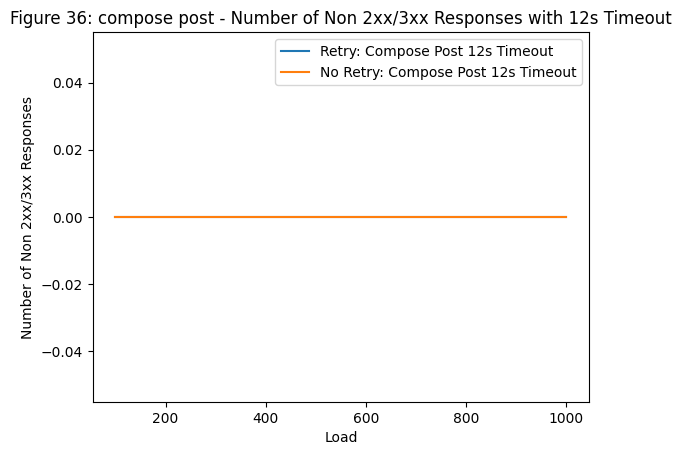

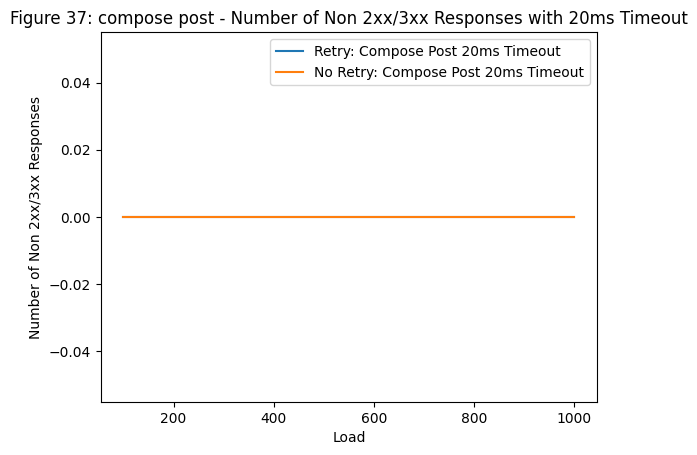

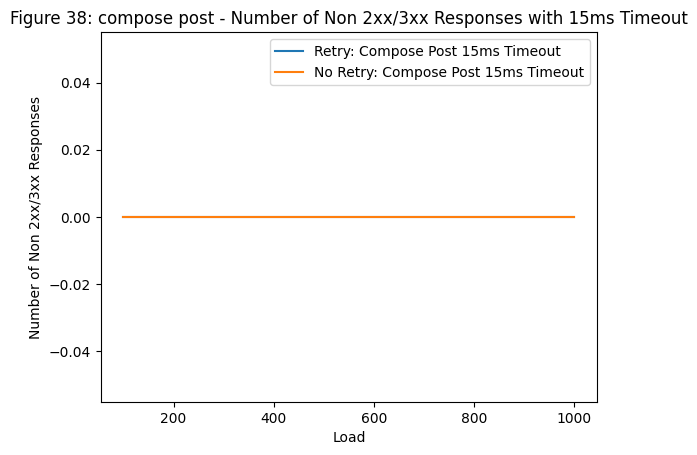

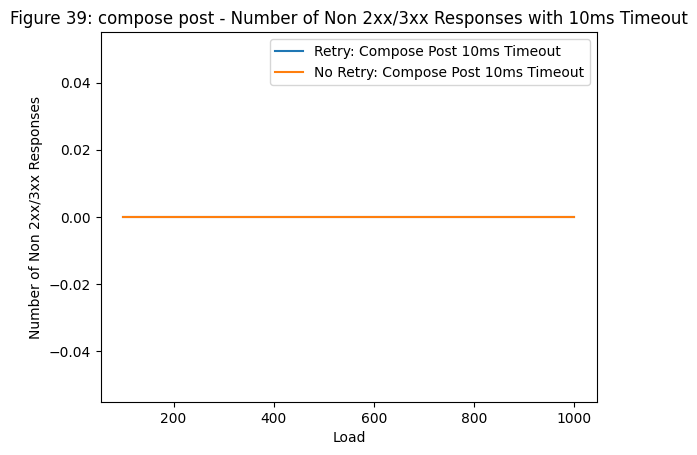

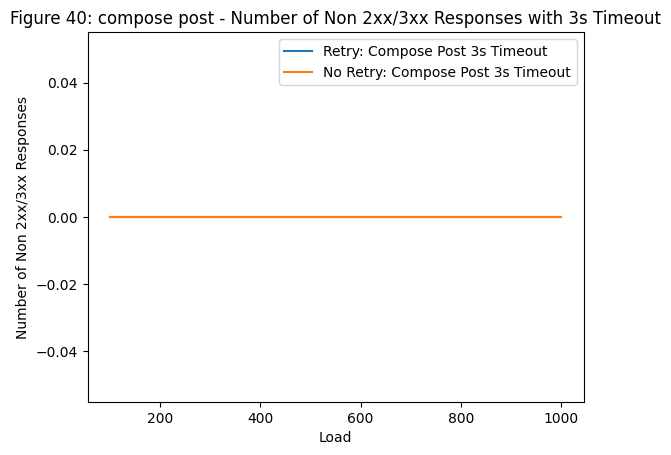

In [90]:
retry_non_2xx_3xx_compose_3_25_28s, retry_non_2xx_3xx_read_home_3_25_28s, retry_non_2xx_3xx_read_user_3_25_28s = get_all_data(retry_home_3_compose_25_user_28s_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_all_5ms, retry_non_2xx_3xx_read_home_all_5ms, retry_non_2xx_3xx_read_user_all_5ms = get_all_data(retry_all_5ms_timeout_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_4_50_100, retry_non_2xx_3xx_read_home_4_50_100, retry_non_2xx_3xx_read_user_4_50_100 = get_all_data(retry_home_4_compose_50_user_100_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_3_12s_28s, retry_non_2xx_3xx_read_home_3_12s_28s, retry_non_2xx_3xx_read_user_3_12s_28s = get_all_data(retry_home_3_compose_12s_user_28s_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_1_20_500, retry_non_2xx_3xx_read_home_1_20_500, retry_non_2xx_3xx_read_user_1_20_500 = get_all_data(retry_home_1_compose_20_user_500_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_2_3s_100, retry_non_2xx_3xx_read_home_2_3s_100, retry_non_2xx_3xx_read_user_2_3s_100 = get_all_data(retry_home_2_compose_3s_user_100_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_6_10_3, retry_non_2xx_3xx_read_home_6_10_3, retry_non_2xx_3xx_read_user_6_10_3 = get_all_data(retry_home_6_compose_10_user_3_non_2xx_3xx_data)
retry_non_2xx_3xx_compose_7_15_50, retry_non_2xx_3xx_read_home_7_15_50, retry_non_2xx_3xx_read_user_7_15_50 = get_all_data(retry_home_7_compose_15_user_50_non_2xx_3xx_data)

plot_gragh(load_range, [retry_non_2xx_3xx_compose_4_50_100, non_2xx_3xx_compose_4_50_100],
                ['Retry: Compose Post 50ms Timeout', 'No Retry: Compose Post 50ms Timeout'],
                "Load", 'Number of Non 2xx/3xx Responses', 'Figure 33: compose pose - Number of Non 2xx/3xx Responses with 50ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_all_5ms, non_2xx_3xx_compose_all_5ms],
            ['Retry: Compose Post 5ms Timeout', 'No Retry: Compose Post 5ms Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 34: compose post - Number of Non 2xx/3xx Responses with 5ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_3_25_28s, non_2xx_3xx_compose_3_25_28s],
            ['Retry: Compose Post 25ms Timeout', 'No Retry: Compose Post 25ms Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 35: compose post - Number of Non 2xx/3xx Responses with 25ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_3_12s_28s, non_2xx_3xx_compose_3_12s_28s],
            ['Retry: Compose Post 12s Timeout', 'No Retry: Compose Post 12s Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 36: compose post - Number of Non 2xx/3xx Responses with 12s Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_1_20_500, non_2xx_3xx_compose_1_20_500],
            ['Retry: Compose Post 20ms Timeout', 'No Retry: Compose Post 20ms Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 37: compose post - Number of Non 2xx/3xx Responses with 20ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_7_15_50, non_2xx_3xx_compose_7_15_50],
            ['Retry: Compose Post 15ms Timeout', 'No Retry: Compose Post 15ms Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 38: compose post - Number of Non 2xx/3xx Responses with 15ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_6_10_3, non_2xx_3xx_compose_6_10_3],
            ['Retry: Compose Post 10ms Timeout', 'No Retry: Compose Post 10ms Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 39: compose post - Number of Non 2xx/3xx Responses with 10ms Timeout')
plot_gragh(load_range, [retry_non_2xx_3xx_compose_2_3s_100, non_2xx_3xx_compose_2_3s_100],
            ['Retry: Compose Post 3s Timeout', 'No Retry: Compose Post 3s Timeout'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Figure 40: compose post - Number of Non 2xx/3xx Responses with 3s Timeout')


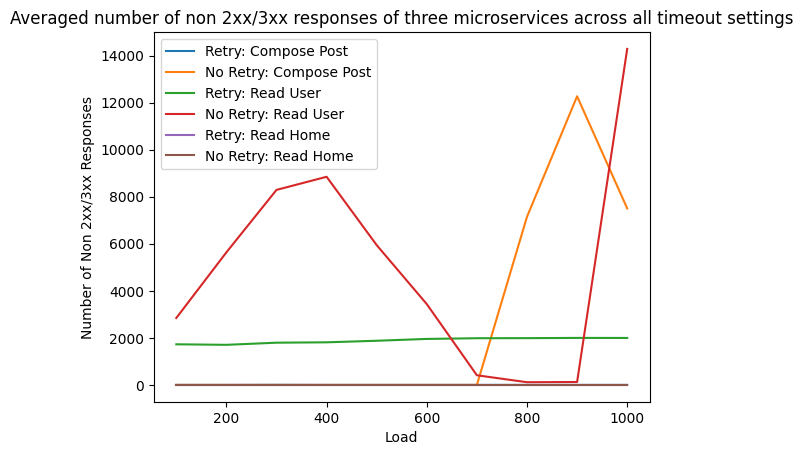

In [92]:
total_retry_non_2xx_3xx_compose = [sum(x) for x in zip(retry_non_2xx_3xx_compose_4_50_100, retry_non_2xx_3xx_compose_all_5ms, retry_non_2xx_3xx_compose_3_25_28s, retry_non_2xx_3xx_compose_3_12s_28s, retry_non_2xx_3xx_compose_1_20_500, retry_non_2xx_3xx_compose_7_15_50, retry_non_2xx_3xx_compose_6_10_3, retry_non_2xx_3xx_compose_2_3s_100)]
total_non_2xx_3xx_compose = [sum(x) for x in zip(non_2xx_3xx_compose_4_50_100, non_2xx_3xx_compose_all_5ms, non_2xx_3xx_compose_3_25_28s, non_2xx_3xx_compose_3_12s_28s, non_2xx_3xx_compose_1_20_500, non_2xx_3xx_compose_7_15_50, non_2xx_3xx_compose_6_10_3, non_2xx_3xx_compose_2_3s_100)]

total_retry_non_2xx_3xx_read_user = [sum(x) for x in zip(retry_non_2xx_3xx_read_user_3_25_28s, retry_non_2xx_3xx_read_user_3_12s_28s, retry_non_2xx_3xx_read_user_1_20_500, retry_non_2xx_3xx_read_user_7_15_50, retry_non_2xx_3xx_read_user_6_10_3, retry_non_2xx_3xx_read_user_2_3s_100)]
total_non_2xx_3xx_read_user = [sum(x) for x in zip(non_2xx_3xx_read_user_3_25_28s, non_2xx_3xx_read_user_3_12s_28s, non_2xx_3xx_read_user_1_20_500, non_2xx_3xx_read_user_7_15_50, non_2xx_3xx_read_user_6_10_3, non_2xx_3xx_read_user_2_3s_100)]

total_retry_non_2xx_3xx_read_home = [sum(x) for x in zip(retry_non_2xx_3xx_read_home_3_25_28s, retry_non_2xx_3xx_read_home_3_12s_28s, retry_non_2xx_3xx_read_home_1_20_500, retry_non_2xx_3xx_read_home_7_15_50, retry_non_2xx_3xx_read_home_6_10_3, retry_non_2xx_3xx_read_home_2_3s_100)]
total_non_2xx_3xx_read_home = [sum(x) for x in zip(non_2xx_3xx_read_home_3_25_28s, non_2xx_3xx_read_home_3_12s_28s, non_2xx_3xx_read_home_1_20_500, non_2xx_3xx_read_home_7_15_50, non_2xx_3xx_read_home_6_10_3, non_2xx_3xx_read_home_2_3s_100)]

plot_gragh(load_range, [total_retry_non_2xx_3xx_compose, total_non_2xx_3xx_compose, total_retry_non_2xx_3xx_read_user, total_non_2xx_3xx_read_user, total_retry_non_2xx_3xx_read_home, total_non_2xx_3xx_read_home],
            ['Retry: Compose Post', 'No Retry: Compose Post', 'Retry: Read User', 'No Retry: Read User', 'Retry: Read Home', 'No Retry: Read Home'],
            "Load", 'Number of Non 2xx/3xx Responses', 'Averaged number of non 2xx/3xx responses of three microservices across all timeout settings')

